In [1]:
%load_ext rpy2.ipython

In [6]:
%%R

library(stringr)
library(readxl)
library(Hmisc)
library(limma)
library(rrcov)
library(factoextra)
library(M3C)
library(caret)
library(glmnet)
library(EBglmnet)
library(pROC)
library(epiR)
library(xgboost)
library(SHAPforxgboost)
library(mltools)
library(ParBayesianOptimization)

sample.IDs
      AD      FTD LewyBody   MCI-AD  MCI-MCI      NDC       OD      VaD 
      85        1        3       22       17       79       11        4 


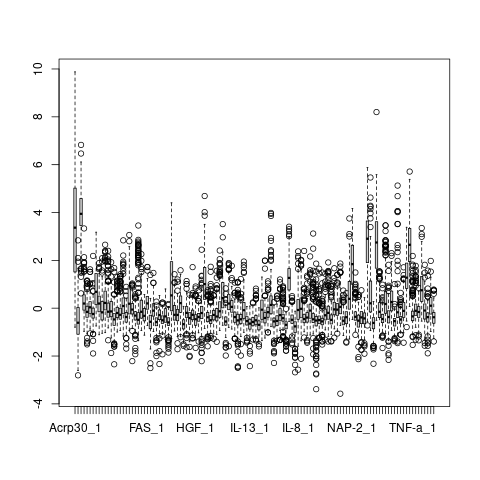

In [7]:
%%R

AD_plasma_protein <- read_excel("../data/external/AD_plasma_protein.xlsx")
AD_plasma_protein <- as.data.frame(AD_plasma_protein)
dim(AD_plasma_protein)
#View(AD_plasma_protein)

# MATT this sets the index
row.names(AD_plasma_protein) <- AD_plasma_protein$CLASS
# MATT this drops the CLASS name column
AD_plasma_protein <- AD_plasma_protein[,names(AD_plasma_protein) %nin% "CLASS"]
dim(AD_plasma_protein)
#View(AD_plasma_protein)

AD_plasma_protein_test <- read_excel("../data/external/AD_plasma_protein_test.xlsx")
AD_plasma_protein_test  <- as.data.frame(AD_plasma_protein_test)
row.names(AD_plasma_protein_test) <- AD_plasma_protein_test$CLASS
AD_plasma_protein_test <- AD_plasma_protein_test[, names(AD_plasma_protein_test)  %nin% "CLASS"]
dim(AD_plasma_protein_test)
#View(AD_plasma_protein_test)

AD_plasma_protein_testOD <- read_excel("../data/external/AD_plasma_protein_testOD.xlsx")
AD_plasma_protein_testOD <- as.data.frame(AD_plasma_protein_testOD)
row.names(AD_plasma_protein_testOD) <- AD_plasma_protein_testOD$CLASS
AD_plasma_protein_testOD <- AD_plasma_protein_testOD[, names(AD_plasma_protein_testOD) %nin% "CLASS"]
dim(AD_plasma_protein_testOD)
#View(AD_plasma_protein_testOD)

AD_plasma_protein_MCI <- read_excel("../data/external/AD_plasma_protein_MCI.xlsx")
AD_plasma_protein_MCI <- as.data.frame(AD_plasma_protein_MCI)
row.names(AD_plasma_protein_MCI) <- AD_plasma_protein_MCI$CLASS
row.names(AD_plasma_protein_MCI)
AD_plasma_protein_MCI <- AD_plasma_protein_MCI[,names(AD_plasma_protein_MCI) %nin% "CLASS"]
dim(AD_plasma_protein_MCI)
#View(AD_plasma_protein_MCI)


# MATT merge the data by the row names
merged.dat <- merge(AD_plasma_protein, AD_plasma_protein_test, by="row.names")
row.names(merged.dat) <- merged.dat$Row.names
row.names(merged.dat)
merged.dat <- merged.dat[,names(merged.dat) %nin% "Row.names"]
colnames(merged.dat)
#View(merged.dat)

merged.dat.2 <- merge(AD_plasma_protein_MCI, AD_plasma_protein_testOD, by="row.names")
row.names(merged.dat.2) <- merged.dat.2$Row.names
row.names(merged.dat.2)
merged.dat.2 <- merged.dat.2[,names(merged.dat.2) %nin% "Row.names"]
colnames(merged.dat.2)

merged.dat.3 <- merge(merged.dat, merged.dat.2, by="row.names")
row.names(merged.dat.3) <- merged.dat.3$Row.names
colnames(merged.dat.3)
merged.dat.3 <- merged.dat.3[,names(merged.dat.3) %nin% "Row.names"]
colnames(merged.dat.3)

# MATT summary like describe, printed to console
# like the min and max over the whole table
summary(as.vector(data.matrix(merged.dat.3)))
sd(as.vector(data.matrix(merged.dat.3)))
boxplot(merged.dat.3)
boxplot(t(merged.dat.3)) # MATT: t = transpose

# counting how many of each sort of data we have (the word stuff is split by underscore and take first part)
(sample.IDs <- as.factor(word(colnames(merged.dat.3), 1, sep = "\\_")))
# value counts?
# the column prefix is the type of patient
# AD = Alzheimer’s Disease
# similar to other datasets
table(sample.IDs)

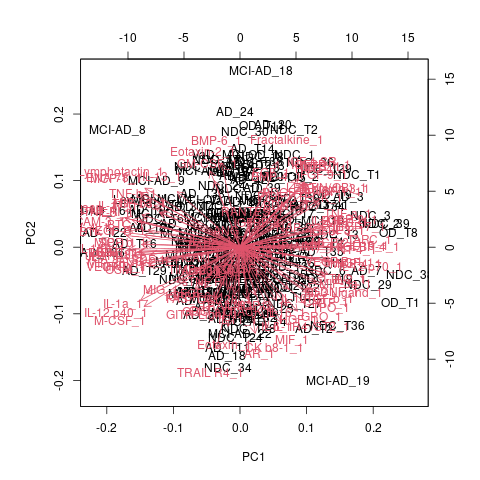

In [9]:
%%R

###

merged.dat.3.norm <- normalizeCyclicLoess(merged.dat.3, iterations=100, method="fast")

set.seed(396)
pcaHub <- PcaHubert(t(merged.dat.3.norm), mcd=F, scale = T, 
                    crit.pca.distances = 0.975)
outliers.pca <- which(pcaHub$flag=='FALSE')
(outliers.pca <- names(outliers.pca))
biplot(pcaHub)

***t-SNE wrapper function***
running...
done.


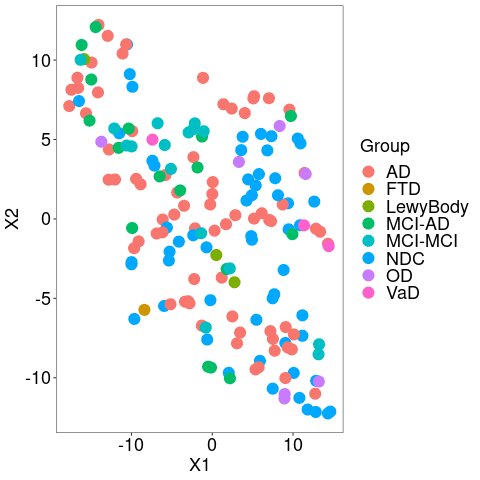

In [10]:
%%R

##########

merged.dat.3.norm.out <- merged.dat.3.norm[, colnames(merged.dat.3.norm) %nin% outliers.pca]

fviz_pca_ind(prcomp(t(merged.dat.3.norm.out)), addEllipses=T, 
             habillage = as.factor(word(colnames(merged.dat.3.norm.out), 1, sep = "\\_")))

tsne(merged.dat.3.norm.out, 
     labels= as.factor(word(colnames(merged.dat.3.norm.out), 1, sep = "\\_")))

In [12]:
%%R

###
colnames(merged.dat.3.norm.out)

  [1] "NDC_4"             "NDC_6"             "NDC_7"            
  [4] "NDC_8"             "NDC_9"             "NDC_10"           
  [7] "NDC_12"            "NDC_13"            "NDC_14"           
 [10] "NDC_15"            "NDC_16"            "NDC_17"           
 [13] "NDC_18"            "NDC_19"            "NDC_20"           
 [16] "NDC_21"            "NDC_22"            "NDC_23"           
 [19] "NDC_24"            "NDC_25"            "NDC_26"           
 [22] "NDC_27"            "NDC_28"            "NDC_29"           
 [25] "NDC_31"            "NDC_32"            "NDC_33"           
 [28] "NDC_34"            "NDC_35"            "NDC_39"           
 [31] "AD_1"              "AD_2"              "AD_3"             
 [34] "AD_4"              "AD_5"              "AD_6"             
 [37] "AD_8"              "AD_10"             "AD_11"            
 [40] "AD_12"             "AD_13"             "AD_14"            
 [43] "AD_15"             "AD_16"             "AD_18"            
 [46] "AD_

In [13]:
%%R

####
NDA.AD.dat <- merged.dat.3.norm.out[, grep("^N|^A", colnames(merged.dat.3.norm.out))]
colnames(NDA.AD.dat)
(NDA.AD.ids <- as.factor(word(colnames(NDA.AD.dat), 1, sep = "\\_")))

  [1] NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC
 [19] NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC AD  AD  AD  AD  AD  AD 
 [37] AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD 
 [55] AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  NDC NDC NDC NDC NDC NDC
 [73] NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC NDC
 [91] NDC NDC AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD 
[109] AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD  AD 
[127] AD  AD 
Levels: AD NDC


In [14]:
%%R

###
MCIvalid.dat <- merged.dat.3.norm.out[, grep("^M", colnames(merged.dat.3.norm.out))]
colnames(MCIvalid.dat)

 [1] "MCI-AD_1"   "MCI-AD_2"   "MCI-AD_3"   "MCI-AD_4"   "MCI-AD_5"  
 [6] "MCI-AD_9"   "MCI-AD_10"  "MCI-AD_11"  "MCI-AD_12"  "MCI-AD_13" 
[11] "MCI-AD_14"  "MCI-AD_15"  "MCI-AD_16"  "MCI-AD_17"  "MCI-AD_20" 
[16] "MCI-AD_21"  "MCI-AD_22"  "MCI-MCI_1"  "MCI-MCI_2"  "MCI-MCI_3" 
[21] "MCI-MCI_4"  "MCI-MCI_5"  "MCI-MCI_6"  "MCI-MCI_8"  "MCI-MCI_9" 
[26] "MCI-MCI_10" "MCI-MCI_11" "MCI-MCI_12" "MCI-MCI_13" "MCI-MCI_14"
[31] "MCI-MCI_15" "MCI-MCI_16" "MCI-MCI_17"


In [15]:
%%R

###

set.seed(396)
trainIndex <- createDataPartition(NDA.AD.ids, p = .8, list = FALSE,  times = 1)
head(trainIndex)

     Resample1
[1,]         2
[2,]         3
[3,]         4
[4,]         5
[5,]         6
[6,]         7


  [1] "NDC_6"      "NDC_7"      "NDC_8"      "NDC_9"      "NDC_10"    
  [6] "NDC_12"     "NDC_13"     "NDC_14"     "NDC_16"     "NDC_17"    
 [11] "NDC_18"     "NDC_20"     "NDC_21"     "NDC_22"     "NDC_23"    
 [16] "NDC_24"     "NDC_25"     "NDC_27"     "NDC_28"     "NDC_32"    
 [21] "NDC_33"     "NDC_34"     "NDC_35"     "NDC_39"     "AD_1"      
 [26] "AD_2"       "AD_3"       "AD_4"       "AD_5"       "AD_6"      
 [31] "AD_8"       "AD_10"      "AD_12"      "AD_13"      "AD_14"     
 [36] "AD_16"      "AD_18"      "AD_21"      "AD_22"      "AD_23"     
 [41] "AD_25"      "AD_26"      "AD_28"      "AD_29"      "AD_30"     
 [46] "AD_31"      "AD_32"      "AD_33"      "AD_35"      "AD_36"     
 [51] "AD_37"      "AD_38"      "AD_40"      "AD_42"      "AD_43"     
 [56] "NDC_T6"     "NDC_T7"     "NDC_T9"     "NDC_T10"    "NDC_T11"   
 [61] "NDC_T12"    "NDC_T14"    "NDC_T15"    "NDC_T16"    "NDC_T17"   
 [66] "NDC_T18"    "NDC_T19"    "NDC_T20"    "NDC_T22"    "NDC_T23"   
 [71] 

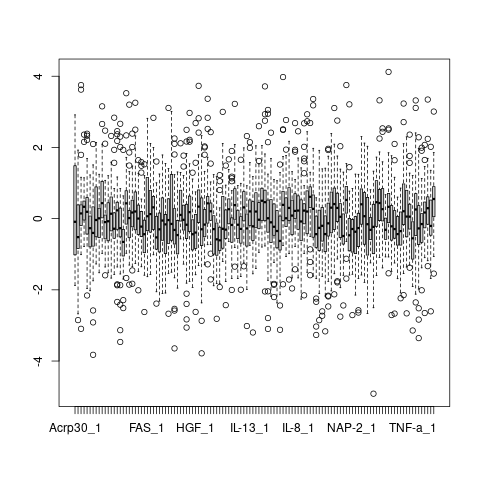

In [16]:
%%R

###
trainset.pre <- NDA.AD.dat[, trainIndex]
(trainset.ids <- as.factor(word(colnames(trainset.pre), 1, sep = "\\_")))
table(trainset.ids)
colnames(trainset.pre)

testset.pre <- NDA.AD.dat[, -trainIndex]
(testset.ids <- as.factor(word(colnames(testset.pre), 1, sep = "\\_")))
table(testset.ids)
colnames(testset.pre)


transf.params.sc <- preProcess(t(trainset.pre), method=c("center", "scale"))
trainset <- t(predict(transf.params.sc, t(trainset.pre)))
testset<- t(predict(transf.params.sc, t(testset.pre)))
testset.MCI <- t(predict(transf.params.sc, t(MCIvalid.dat)))

summary(as.vector(data.matrix(trainset)))
sd(as.vector(data.matrix(trainset)))
boxplot(trainset)
boxplot(t(trainset))

summary(as.vector(data.matrix(testset)))
sd(as.vector(data.matrix(testset)))
boxplot(testset)
boxplot(t(testset))

summary(as.vector(data.matrix(testset.MCI)))
sd(as.vector(data.matrix(testset.MCI)))
boxplot(testset.MCI)
boxplot(t(testset.MCI))


merged.sc <- merge(trainset, testset, by="row.names")
row.names(merged.sc) <- merged.sc$Row.names
colnames(merged.sc)
dim(merged.sc)
merged.sc <- merged.sc[, colnames(merged.sc) %nin% "Row.names"]
dim(merged.sc)
# View(merged.sc)

merged.sc.2 <- merge(merged.sc, testset.MCI, by="row.names")
row.names(merged.sc.2) <- merged.sc.2$Row.names
colnames(merged.sc.2)
dim(merged.sc.2)
merged.sc.3 <- merged.sc.2[, colnames(merged.sc.2) %nin% "Row.names"]
dim(merged.sc.3)

colnames(merged.sc.3)

***t-SNE wrapper function***
running...
done.


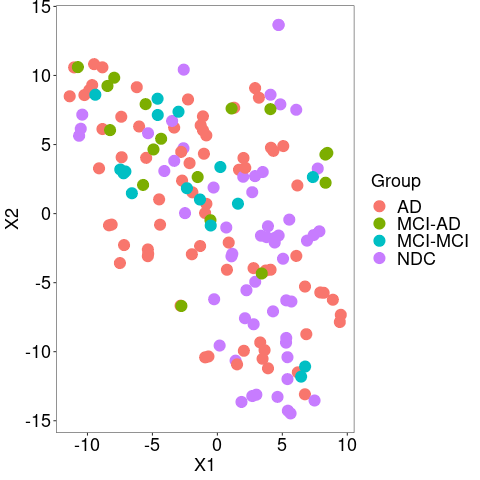

In [17]:
%%R

###

(merged.sc.3.sample.IDs <- as.factor(word(colnames(merged.sc.3), 1, sep = "\\_")))
table(merged.sc.3.sample.IDs)

fviz_pca_ind(prcomp(t(merged.sc.3)), addEllipses=T,
             habillage = merged.sc.3.sample.IDs)

tsne(merged.sc.3, labels= merged.sc.3.sample.IDs)

In [18]:
%%R

#################

colnames(trainset) <- substring(colnames(trainset), 1,1)
trainset <- trainset[,order(colnames(trainset))]
colnames(trainset)
trainset.t <- t(trainset)

colnames(testset) <- substring(colnames(testset), 1,1)
testset <- testset[,order(colnames(testset))]
colnames(testset)
testset.t <- t(testset)

(trainset.NA <- relevel(as.factor(colnames(trainset)), ref="N"))
(testset.NA <- relevel(as.factor(colnames(testset)), ref="N"))

(trainset.NA.01 <- ifelse(trainset.NA=="N",0,1))
(testset.NA.01 <- ifelse(testset.NA=="N",0,1))

(tab.train.test <- matrix(c(sum(trainset.NA=="N"),
                            sum(trainset.NA=="A"),
                            sum(testset.NA=="N"),
                            sum(testset.NA=="A")), 
                          ncol=2, byrow=T))

fisher.test(tab.train.test) 


	Fisher's Exact Test for Count Data

data:  tab.train.test
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3751941 2.6549292
sample estimates:
odds ratio 
 0.9875558 



In [20]:
%%R

#####
############################

set.seed(396)
cv.EBglmnet.lasso <- cv.EBglmnet(trainset.t, trainset.NA.01, family="binomial",
            prior="lasso", nfolds = 10)

cv.EBglmnet.lasso$`optimal hyperparameter`


glmnetfit.lasso <- glmnet(trainset.t, trainset.NA, 
                       family=binomial(link = "logit"), alpha=1)

coeffs.lasso.min <- coef(glmnetfit.lasso, 
                      s = cv.EBglmnet.lasso$`optimal hyperparameter`[1])

coeffs.lasso.min.2  <- as.data.frame(as.matrix(coeffs.lasso.min))
(picked.lasso.min <-subset(coeffs.lasso.min.2, lambda !=0))

dim(picked.lasso.min)
#35

picked.lasso <- row.names(picked.lasso.min)[-1]

(train.picked.lasso <- data.frame(t(trainset[row.names(trainset) %in% picked.lasso,])))

(train.picked.lasso.wNAstatus <- train.picked.lasso)
train.picked.lasso.wNAstatus$NAstatus <- trainset.NA


(glm.lasso <- glm(NAstatus ~., binomial(link = "logit"), data=train.picked.lasso.wNAstatus))
(summary(glm.lasso))
exp(cbind(coef(glm.lasso), confint(glm.lasso))) 
#ERROR overfit - do ridge

plot(roc(glm.lasso$y, glm.lasso$fitted) , print.auc=TRUE)
plot(roc(glm.lasso$y, glm.lasso$fitted) , print.thres=TRUE, print.auc=TRUE)
threshold=0.5
predicted <-ifelse(predict(glm.lasso, type="response")>threshold, 1, 0)
observed <-glm.lasso$y
table(predicted, observed)
#set.seed(1)
ci.auc(glm.lasso$y, glm.lasso$fitted)#,  method="boot")

#D+T+ = a
#D-T+ = b
#D+T- = c
#D-T- = d
epi.tests(c(38,0,0,33), method = "exact", digits = 2, conf.level = 0.95)

Empirical Bayes LASSO Logistic Model (Normal + Exponential prior) 10 fold cross-validation
Waiting for profiling to be done...
Error in approx(sp$y, sp$x, xout = cutoff) : 
  need at least two non-NA values to interpolate
In addition: There were 50 or more warnings (use warnings() to see the first 50)
Error in approx(sp$y, sp$x, xout = cutoff) : 
  need at least two non-NA values to interpolate


RInterpreterError: Failed to parse and evaluate line '\n#####\n############################\n\nset.seed(396)\ncv.EBglmnet.lasso <- cv.EBglmnet(trainset.t, trainset.NA.01, family="binomial",\n            prior="lasso", nfolds = 10)\n\ncv.EBglmnet.lasso$`optimal hyperparameter`\n\n\nglmnetfit.lasso <- glmnet(trainset.t, trainset.NA, \n                       family=binomial(link = "logit"), alpha=1)\n\ncoeffs.lasso.min <- coef(glmnetfit.lasso, \n                      s = cv.EBglmnet.lasso$`optimal hyperparameter`[1])\n\ncoeffs.lasso.min.2  <- as.data.frame(as.matrix(coeffs.lasso.min))\n(picked.lasso.min <-subset(coeffs.lasso.min.2, lambda !=0))\n\ndim(picked.lasso.min)\n#35\n\npicked.lasso <- row.names(picked.lasso.min)[-1]\n\n(train.picked.lasso <- data.frame(t(trainset[row.names(trainset) %in% picked.lasso,])))\n\n(train.picked.lasso.wNAstatus <- train.picked.lasso)\ntrain.picked.lasso.wNAstatus$NAstatus <- trainset.NA\n\n\n(glm.lasso <- glm(NAstatus ~., binomial(link = "logit"), data=train.picked.lasso.wNAstatus))\n(summary(glm.lasso))\nexp(cbind(coef(glm.lasso), confint(glm.lasso))) \n#ERROR overfit - do ridge\n\nplot(roc(glm.lasso$y, glm.lasso$fitted) , print.auc=TRUE)\nplot(roc(glm.lasso$y, glm.lasso$fitted) , print.thres=TRUE, print.auc=TRUE)\nthreshold=0.5\npredicted <-ifelse(predict(glm.lasso, type="response")>threshold, 1, 0)\nobserved <-glm.lasso$y\ntable(predicted, observed)\n#set.seed(1)\nci.auc(glm.lasso$y, glm.lasso$fitted)#,  method="boot")\n\n#D+T+ = a\n#D-T+ = b\n#D+T- = c\n#D-T- = d\nepi.tests(c(38,0,0,33), method = "exact", digits = 2, conf.level = 0.95)\n'.
R error message: 'Error in approx(sp$y, sp$x, xout = cutoff) : \n  need at least two non-NA values to interpolate'
R stdout:
Waiting for profiling to be done...
Error in approx(sp$y, sp$x, xout = cutoff) : 
  need at least two non-NA values to interpolate
In addition: There were 50 or more warnings (use warnings() to see the first 50)

95% CI: 0.7668-1 (DeLong)


Setting levels: control = N, case = A
Setting direction: controls < cases
Setting levels: control = N, case = A
Setting direction: controls < cases
Setting levels: control = N, case = A
Setting direction: controls < cases


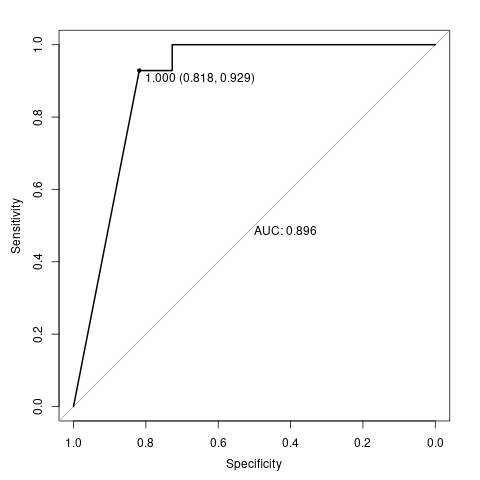

In [21]:
%%R

###################

(test.picked.lasso <- data.frame(t(testset[row.names(testset) %in% picked.lasso,])))

(test.picked.lasso.wNAstatus <- test.picked.lasso)
test.picked.lasso.wNAstatus$NAstatus <- testset.NA

(testset.predict.lasso <- predict(glm.lasso, newdata = test.picked.lasso, type = "response"))

plot(roc(testset.NA, testset.predict.lasso) , print.auc=TRUE)
plot(roc(testset.NA, testset.predict.lasso) , print.thres=TRUE, print.auc=TRUE)
threshold=0.5
predicted <-ifelse(testset.predict.lasso>threshold, 1, 0)
observed <-testset.NA
table(predicted, observed)
#set.seed(1)
ci.auc(testset.NA, testset.predict.lasso)#,  method="boot")

          Outcome +    Outcome -      Total
Test +           14            0         14
Test -            2            9         11
Total            16            9         25

Point estimates and 95% CIs:
--------------------------------------------------------------
Apparent prevalence *                  0.56 (0.35, 0.76)
True prevalence *                      0.64 (0.43, 0.82)
Sensitivity *                          0.88 (0.62, 0.98)
Specificity *                          1.00 (0.66, 1.00)
Positive predictive value *            1.00 (0.77, 1.00)
Negative predictive value *            0.82 (0.48, 0.98)
Positive likelihood ratio              Inf (NaN, Inf)
Negative likelihood ratio              0.12 (0.03, 0.46)
False T+ proportion for true D- *      0.00 (0.00, 0.34)
False T- proportion for true D+ *      0.12 (0.02, 0.38)
False T+ proportion for T+ *           0.00 (0.00, 0.23)
False T- proportion for T- *           0.18 (0.02, 0.52)
Correctly classified proportion *      0.92 (0.74,

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
In addition: Warning message:
Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold 


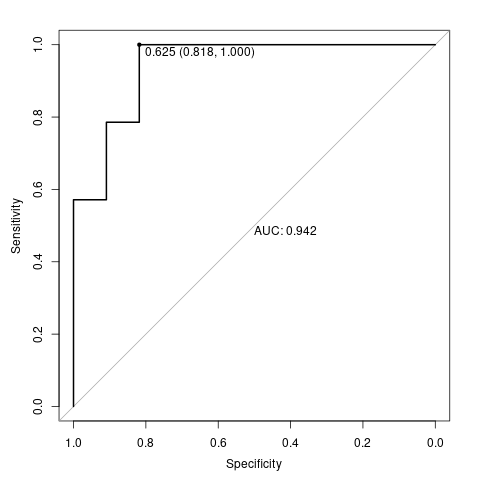

In [22]:
%%R

###########################

#set.seed(1)
cv.ridge.lasso <- cv.glmnet(as.matrix(train.picked.lasso), trainset.NA,
                            family=binomial(link = "logit"), nfolds=length(trainset.NA), 
                            alpha=0, type.measure = "deviance")

ridge.fit.lasso <- glmnet(as.matrix(train.picked.lasso), trainset.NA, 
                    family=binomial(link = "logit"), alpha=0)

coeffs.ridge.lasso <- coef(ridge.fit.lasso, s = cv.ridge.lasso$lambda.min)


coefs.ridge.lasso.trainset <- data.frame(matrix(coeffs.ridge.lasso))

trainset.internalpredict.lasso.ridge <- predict(ridge.fit.lasso, 
                                                s=cv.ridge.lasso$lambda.min,
                                                type="response",
                                                newx=as.matrix(train.picked.lasso))


plot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.lasso.ridge)) , print.auc=TRUE)
plot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.lasso.ridge)) , print.thres=TRUE, print.auc=TRUE)
threshold=0.5
predicted <-ifelse(as.numeric(trainset.internalpredict.lasso.ridge)>threshold, 1, 0)
observed <-trainset.NA.01
table(predicted, observed)
#set.seed(1)
ci.auc(trainset.NA.01, as.numeric(trainset.internalpredict.lasso.ridge))#,  method="boot")

#D+T+ = a
#D-T+ = b
#D+T- = c
#D-T- = d
epi.tests(c(58,7,1,38), method = "exact", digits = 2, conf.level = 0.95)
#Sensitivity *                          0.98 (0.91, 1.00)
#Specificity *                          0.84 (0.71, 0.94)
#Positive predictive value *            0.89 (0.79, 0.96)
#Negative predictive value *            0.97 (0.87, 1.00)



testset.predict.lasso.ridge <- predict(ridge.fit.lasso, s=cv.ridge.lasso$lambda.min,
                                       type="response",
                                       newx=as.matrix(test.picked.lasso))

plot(roc(testset.NA.01, as.numeric(testset.predict.lasso.ridge)) , print.auc=TRUE)
#AUROC-0.942
plot(roc(testset.NA.01, as.numeric(testset.predict.lasso.ridge)) , print.thres=TRUE, print.auc=TRUE)
threshold=0.625
predicted <-ifelse(as.numeric(testset.predict.lasso.ridge)>threshold, 1, 0)
observed <-testset.NA.01
table(predicted, observed)
#set.seed(1)
ci.auc(testset.NA.01, as.numeric(testset.predict.lasso.ridge))#,  method="boot")

#D+T+ = a
#D-T+ = b
#D+T- = c
#D-T- = d
epi.tests(c(14,0,2,9), method = "exact", digits = 2, conf.level = 0.95)
#Sensitivity *                          0.88 (0.62, 0.98)
#Specificity *                          1.00 (0.66, 1.00)
#Positive predictive value *            1.00 (0.77, 1.00)
#Negative predictive value *            0.82 (0.48, 0.98)

In [23]:
%%R

###################################################
##EN##############################################

set.seed(396)
cv.EBglmnet.EN <- cv.EBglmnet(trainset.t, trainset.NA.01, family="binomial",
            prior="elastic net", nfolds = 10)

###
glmnetfit.EN<- glmnet(trainset.t, trainset.NA, 
                  family=binomial(link = "logit"),
                       alpha=cv.EBglmnet.EN$`optimal hyperparameter`[1])

coeffs.EN.min <- coef(glmnetfit.EN, 
                         s = cv.EBglmnet.EN$`optimal hyperparameter`[2])

coeffs.EN.min.2  <- as.data.frame(as.matrix(coeffs.EN.min))
(picked.EN.min <-subset(coeffs.EN.min.2, lambda !=0))

dim(picked.EN.min)
#89


(train.picked.EN <- data.frame(t(trainset[row.names(trainset) %in% 
                                         row.names(picked.EN.min)[-1],])))

(train.picked.EN.wNAstatus <- train.picked.EN)
train.picked.EN.wNAstatus$NAstatus <- trainset.NA


(glm.EN <- glm(NAstatus ~., binomial(link = "logit"), data=train.picked.EN.wNAstatus))
(summary(glm.EN))
exp(cbind(coef(glm.EN), confint(glm.EN))) 
#ERROR overfit - do ridge below

plot(roc(glm.EN$y, glm.EN$fitted) , print.auc=TRUE)
plot(roc(glm.EN$y, glm.EN$fitted) , print.thres=TRUE, print.auc=TRUE)
threshold=0.5
predicted <-ifelse(predict(glm.EN, type="response")>threshold, 1, 0)
observed <-glm.EN$y
table(predicted, observed)
#set.seed(1)
ci.auc(glm.EN$y, glm.EN$fitted)#,  method="boot")

#D+T+ = a
#D-T+ = b
#D+T- = c
#D-T- = d
epi.tests(c(38,0,0,33), method = "exact", digits = 2, conf.level = 0.95)

Empirical Bayes Elastic Net Logistic Model:  10 fold cross-validation
Testing alpha 1 / 9 :		alpha:  0.9 	lambda: 0.001717255 	 max log Likelihood -0.3643965 
Testing alpha 2 / 9 :		alpha:  0.8 	lambda: 0.001717255 	 max log Likelihood -0.3614001 
Testing alpha 3 / 9 :		alpha:  0.7 	lambda: 0.001717255 	 max log Likelihood -0.3636967 
Testing alpha 4 / 9 :		alpha:  0.6 	lambda: 0.0008299372 	 max log Likelihood -0.3657883 
Testing alpha 5 / 9 :		alpha:  0.5 	lambda: 0.0008299372 	 max log Likelihood -0.3575473 
Testing alpha 6 / 9 :		alpha:  0.4 	lambda: 0.0008299372 	 max log Likelihood -0.3569428 
Testing alpha 7 / 9 :		alpha:  0.3 	lambda: 0.0008299372 	 max log Likelihood -0.3551448 
Testing alpha 8 / 9 :		alpha:  0.2 	lambda: 0.0008299372 	 max log Likelihood -0.3545332 
Testing alpha 9 / 9 :		alpha:  0.1 	lambda: 0.0008299372 	 max log Likelihood -0.3499381 
Waiting for profiling to be done...
Error in approx(sp$y, sp$x, xout = cutoff) : 
  need at least two non-NA values to inte

RInterpreterError: Failed to parse and evaluate line '\n###################################################\n##EN##############################################\n\nset.seed(396)\ncv.EBglmnet.EN <- cv.EBglmnet(trainset.t, trainset.NA.01, family="binomial",\n            prior="elastic net", nfolds = 10)\n\n###\nglmnetfit.EN<- glmnet(trainset.t, trainset.NA, \n                  family=binomial(link = "logit"),\n                       alpha=cv.EBglmnet.EN$`optimal hyperparameter`[1])\n\ncoeffs.EN.min <- coef(glmnetfit.EN, \n                         s = cv.EBglmnet.EN$`optimal hyperparameter`[2])\n\ncoeffs.EN.min.2  <- as.data.frame(as.matrix(coeffs.EN.min))\n(picked.EN.min <-subset(coeffs.EN.min.2, lambda !=0))\n\ndim(picked.EN.min)\n#89\n\n\n(train.picked.EN <- data.frame(t(trainset[row.names(trainset) %in% \n                                         row.names(picked.EN.min)[-1],])))\n\n(train.picked.EN.wNAstatus <- train.picked.EN)\ntrain.picked.EN.wNAstatus$NAstatus <- trainset.NA\n\n\n(glm.EN <- glm(NAstatus ~., binomial(link = "logit"), data=train.picked.EN.wNAstatus))\n(summary(glm.EN))\nexp(cbind(coef(glm.EN), confint(glm.EN))) \n#ERROR overfit - do ridge below\n\nplot(roc(glm.EN$y, glm.EN$fitted) , print.auc=TRUE)\nplot(roc(glm.EN$y, glm.EN$fitted) , print.thres=TRUE, print.auc=TRUE)\nthreshold=0.5\npredicted <-ifelse(predict(glm.EN, type="response")>threshold, 1, 0)\nobserved <-glm.EN$y\ntable(predicted, observed)\n#set.seed(1)\nci.auc(glm.EN$y, glm.EN$fitted)#,  method="boot")\n\n#D+T+ = a\n#D-T+ = b\n#D+T- = c\n#D-T- = d\nepi.tests(c(38,0,0,33), method = "exact", digits = 2, conf.level = 0.95)\n'.
R error message: 'Error in approx(sp$y, sp$x, xout = cutoff) : \n  need at least two non-NA values to interpolate'
R stdout:
Waiting for profiling to be done...
Error in approx(sp$y, sp$x, xout = cutoff) : 
  need at least two non-NA values to interpolate
In addition: There were 50 or more warnings (use warnings() to see the first 50)

In [24]:
%%R

###################

(test.picked.EN <- data.frame(t(testset[row.names(testset) %in% 
                                            row.names(picked.EN.min)[-1],])))

(test.picked.EN.wNAstatus <- test.picked.EN)
test.picked.EN.wNAstatus$NAstatus <- testset.NA

(testset.predict.EN <- predict(glm.EN, newdata = test.picked.EN, type = "response"))

plot(roc(testset.NA, testset.predict.EN) , print.auc=TRUE)
#AUROC=0.903
plot(roc(testset.NA, testset.predict.EN) , print.thres=TRUE, print.auc=TRUE)
threshold=0.5
predicted <-ifelse(testset.predict.EN>threshold, 1, 0)
observed <-testset.NA
table(predicted, observed)
#set.seed(1)
ci.auc(testset.NA, testset.predict.EN)#,  method="boot")

95% CI: 0.3723-0.8225 (DeLong)


Setting levels: control = N, case = A
Setting direction: controls > cases
Setting levels: control = N, case = A
Setting direction: controls > cases
Setting levels: control = N, case = A
Setting direction: controls > cases


In [25]:
%%R

######

cv.ridge.EN <- cv.glmnet(as.matrix(train.picked.EN), trainset.NA,
                         family=binomial(link = "logit"), nfolds=length(trainset.NA), 
                         alpha=0, type.measure = "deviance")


ridge.fit.EN <- glmnet(as.matrix(train.picked.EN), trainset.NA, 
                       family=binomial(link = "logit"), alpha=0)

coeffs.ridge.EN <- coef(ridge.fit.EN, s = cv.ridge.EN$lambda.min)

(trainset.predict.ridge.EN <- predict(ridge.fit.EN, newx = as.matrix(train.picked.EN), 
                                      type = "response"))

coefs.ridge.EN.trainset <- data.frame(matrix(coeffs.ridge.EN))

trainset.internalpredict.EN <- predict(ridge.fit.EN, s=cv.ridge.EN$lambda.min,
                                       type="response",
                                       newx=as.matrix(train.picked.EN))

plot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.EN)) , print.auc=TRUE)
#AUROC=1
plot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.EN)) , print.thres=TRUE, print.auc=TRUE)
threshold=0.5
predicted <-ifelse(as.numeric(trainset.internalpredict.EN)>threshold, 1, 0)
observed <-trainset.NA.01
table(predicted, observed)
#set.seed(1)
ci.auc(trainset.NA.01, as.numeric(trainset.internalpredict.EN))#,  method="boot")

#D+T+ = a
#D-T+ = b
#D+T- = c
#D-T- = d
epi.tests(c(58,0,1,45), method = "exact", digits = 2, conf.level = 0.95)
#Sensitivity *                          0.98 (0.91, 1.00)
#Specificity *                          1.00 (0.92, 1.00)
#Positive predictive value *            1.00 (0.94, 1.00)
#Negative predictive value *            0.98 (0.88, 1.00)


testset.predict.EN.ridge <- predict(ridge.fit.EN, s=cv.ridge.EN$lambda.min,
                                    type="response",
                                    newx=as.matrix(test.picked.EN))


plot(roc(testset.NA.01, as.numeric(testset.predict.EN.ridge)) , print.auc=TRUE)
#AUROC=0.974
plot(roc(testset.NA.01, as.numeric(testset.predict.EN.ridge)) , print.thres=TRUE, print.auc=TRUE)
threshold=0.797
predicted.EN.ridge <-ifelse(as.numeric(testset.predict.EN.ridge)>threshold, 1, 0)
table(predicted.EN.ridge, testset.NA.01)
#set.seed(1)
ci.auc(testset.NA.01, as.numeric(testset.predict.EN.ridge))#,  method="boot")

#D+T+ = a
#D-T+ = b
#D+T- = c
#D-T- = d
epi.tests(c(10,1,1,13), method = "exact", digits = 2, conf.level = 0.95)
#True prevalence *                      0.56 (0.35, 0.76)
#Sensitivity *                          0.64 (0.35, 0.87)
#Specificity *                          1.00 (0.72, 1.00)
#Positive predictive value *            1.00 (0.66, 1.00)

          Outcome +    Outcome -      Total
Test +           10            1         11
Test -            1           13         14
Total            11           14         25

Point estimates and 95% CIs:
--------------------------------------------------------------
Apparent prevalence *                  0.44 (0.24, 0.65)
True prevalence *                      0.44 (0.24, 0.65)
Sensitivity *                          0.91 (0.59, 1.00)
Specificity *                          0.93 (0.66, 1.00)
Positive predictive value *            0.91 (0.59, 1.00)
Negative predictive value *            0.93 (0.66, 1.00)
Positive likelihood ratio              12.73 (1.91, 84.91)
Negative likelihood ratio              0.10 (0.02, 0.64)
False T+ proportion for true D- *      0.07 (0.00, 0.34)
False T- proportion for true D+ *      0.09 (0.00, 0.41)
False T+ proportion for T+ *           0.09 (0.00, 0.41)
False T- proportion for T- *           0.07 (0.00, 0.34)
Correctly classified proportion *      0.92 (

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
In addition: Warning message:
Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold 


In [26]:
%%R

########################
###XGB 

########
trainset.xgb <- xgb.DMatrix(trainset.t, label=trainset.NA.01)
testset.xgb <- xgb.DMatrix(testset.t, label=testset.NA.01)

###

table(trainset.NA.01)
#trainset.NA.01
#0  1 
#45 58
#59 1's followed by 45 0's, so need to pick from 1:58, and 59:103


(Folds.ind <- folds(trainset.NA.01, nfolds=10, stratified=T, seed=396))


(Folds <- list(
  Fold1 = as.integer(seq(1,103,by=1)[Folds.ind==1])
  , Fold2 = as.integer(seq(1,103,by=1)[Folds.ind==2])
  , Fold3 = as.integer(seq(1,103,by=1)[Folds.ind==3])
  , Fold4 = as.integer(seq(1,103,by=1)[Folds.ind==4])
  , Fold5 = as.integer(seq(1,103,by=1)[Folds.ind==5])
  , Fold6 = as.integer(seq(1,103,by=1)[Folds.ind==6])
  , Fold7 = as.integer(seq(1,103,by=1)[Folds.ind==7])
  , Fold8 = as.integer(seq(1,103,by=1)[Folds.ind==8])
  , Fold9 = as.integer(seq(1,103,by=1)[Folds.ind==9])
  , Fold10 = as.integer(seq(1,103,by=1)[Folds.ind==10]) 
))


scoringFunction <- function(eta, max_depth, gamma, min_child_weight, 
                            subsample, colsample_bytree, 
                            alpha, lambda) {
  
  
  Pars <- list( booster = "gbtree", objective = "binary:logistic"
                , eta=eta
                , max_depth = max_depth
                , gamma=gamma 
                , min_child_weight = min_child_weight
                , subsample = subsample
                , colsample_bytree=colsample_bytree
                , alpha=0 #alpha
                , lambda=1#lambda
                , eval_metric = "error"
  )
  
  xgbcv <- xgb.cv(
    params = Pars
    , data = trainset.xgb
    , nround = 100
    , folds = Folds
    , prediction = TRUE
    , showsd = TRUE
    , early_stopping_rounds = 10
    , maximize = TRUE
    , verbose = 0)
  
  return(
    list( 
      Score = max(xgbcv$evaluation_log$test_error_mean)
      , nrounds = xgbcv$best_iteration
    )
  )
}

bounds <- list( 
  eta= c(0.01, 0.5),
  max_depth = c(2L, 6L),
  gamma= c(0, 1),  #0,1
  min_child_weight = c(0, 2),
  subsample = c(0.8, 1), 
  colsample_bytree= c(0.8, 1) 
  #,alpha= c(0,0.5)
  #,lambda= c(0,1)
)


set.seed(396) 
optObj <- bayesOpt(
  FUN = scoringFunction
  , bounds = bounds
  , initPoints = 7
  , iters.n = 10
  , iters.k = 2
)

optObj$scoreSummary
getBestPars(optObj)


Running initial scoring function 7 times in 1 thread(s)...  1.231 seconds

Starting Epoch 1 
  1) Fitting Gaussian Process...
  2) Running local optimum search...        18.327 seconds
  3) Running FUN 2 times in 1 thread(s)...  0.353 seconds

Starting Epoch 2 
  1) Fitting Gaussian Process...
  2) Running local optimum search...        35.196 seconds
  3) Running FUN 2 times in 1 thread(s)...  0.355 seconds

Starting Epoch 3 
  1) Fitting Gaussian Process...
  2) Running local optimum search...        45.391 seconds
  3) Running FUN 2 times in 1 thread(s)...  0.381 seconds

Starting Epoch 4 
  1) Fitting Gaussian Process...
  2) Running local optimum search...        38.113 seconds
  3) Running FUN 2 times in 1 thread(s)...  0.381 seconds

Starting Epoch 5 
  1) Fitting Gaussian Process...
  2) Running local optimum search...        29.674 seconds
  3) Running FUN 2 times in 1 thread(s)...  0.376 seconds
$eta
[1] 0.4326678

$max_depth
[1] 6

$gamma
[1] 0.5916805

$min_child_weight
[1

In [27]:
%%R

###

set.seed(396)
xgbcv <- xgb.cv(params = list(booster = "gbtree", objective = "binary:logistic",
                              eta=getBestPars(optObj)$eta, 
                              max_depth=getBestPars(optObj)$max_depth,
                              gamma=getBestPars(optObj)$gamma, 
                              min_child_weight=getBestPars(optObj)$min_child_weight, 
                              subsample=getBestPars(optObj)$subsample, 
                              colsample_bytree=getBestPars(optObj)$colsample_bytree,
                              alpha=0, #getBestPars(optObj)$alpha, 
                              lambda=1 #getBestPars(optObj)$lambda
                              ),
                data = trainset.xgb, 
                folds = Folds, metrics="error",
                nrounds = 100, early_stopping_rounds=10,
                print_every_n = 10)

print(xgbcv)

set.seed(1)
xgb.initial <- xgb.train(params = list(booster = "gbtree", objective = "binary:logistic",
                                       eta=getBestPars(optObj)$eta, 
                                       max_depth=getBestPars(optObj)$max_depth,
                                       gamma=getBestPars(optObj)$gamma, 
                                       min_child_weight=getBestPars(optObj)$min_child_weight, 
                                       subsample=getBestPars(optObj)$subsample, 
                                       colsample_bytree=getBestPars(optObj)$colsample_bytree,
                                       alpha=0, #getBestPars(optObj)$alpha, 
                                       lambda=1 #getBestPars(optObj)$lambda
                                       ),
                         data = trainset.xgb, nrounds = xgbcv$best_iteration)

(importance.initial <- xgb.importance(feature_names = colnames(trainset.t), 
                                      model = xgb.initial))

[1]	train-error:0.043104+0.015870	test-error:0.398182+0.092513 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 10 rounds.

[11]	train-error:0.000000+0.000000	test-error:0.251818+0.107492 
[21]	train-error:0.000000+0.000000	test-error:0.231818+0.123399 
Stopping. Best iteration:
[12]	train-error:0.000000+0.000000	test-error:0.221818+0.103748

##### xgb.cv 10-folds
 iter train_error_mean train_error_std test_error_mean test_error_std
    1      0.043104254     0.015870491       0.3981818     0.09251312
    2      0.015088827     0.008614155       0.3681818     0.09246398
    3      0.001086957     0.003260870       0.3090909     0.11741007
    4      0.002162225     0.004324530       0.3290909     0.07327070
    5      0.000000000     0.000000000       0.3009091     0.08094994
    6      0.000000000     0.000000000       0.3009091     0.05052616
    7      0.000000000     0.000000000       0.2700000     0.07735824

95% CI: 0.6366-1 (DeLong)


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = N, case = A
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = N, case = A
Setting direction: controls < cases
In addition: Warning message:
In ci.auc.roc(roc = roc, ...) :
  ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.


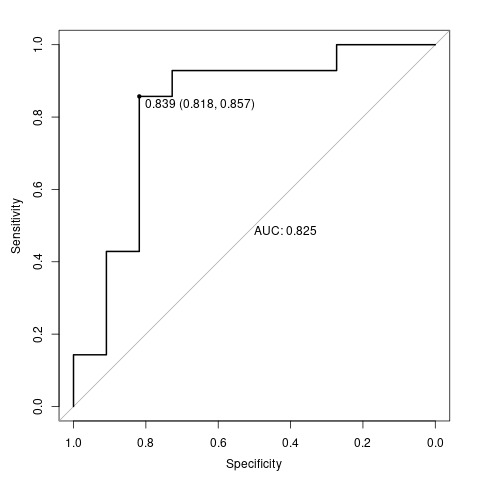

In [28]:
%%R

#######
(trainset.predict.xgb <- predict(xgb.initial, newdata = trainset.t))

plot(roc(trainset.NA.01, trainset.predict.xgb) , print.auc=TRUE)
plot(roc(trainset.NA.01, trainset.predict.xgb) , print.thres=TRUE, print.auc=TRUE)
threshold=0.5
predicted <-ifelse(trainset.predict.xgb >threshold, 1, 0)
table(predicted, trainset.NA.01)
ci.auc(trainset.NA, trainset.predict.xgb)


#
(testset.predict.xgb <- predict(xgb.initial, newdata = testset.t))

plot(roc(testset.NA.01, testset.predict.xgb) , print.auc=TRUE)
plot(roc(testset.NA.01, testset.predict.xgb) , print.thres=TRUE, print.auc=TRUE)
#AUROC=0.935
threshold=0.693
predicted <-ifelse(testset.predict.xgb >threshold, 1, 0)
table(predicted, testset.NA.01)
#set.seed(1)
ci.auc(testset.NA, testset.predict.xgb)#,  method="boot")

###########
#$eta = [1] 0.07290897
#$max_depth = [1] 6
#$gamma = [1] 0.03248671
#$min_child_weight = [1] 0.2382293
#$subsample = [1] 0.8
#$colsample_bytree = [1] 1

#############################

In [29]:
%%R

Metrics::recall(testset.NA.01, testset.predict.xgb)
Metrics::precision(testset.NA.01, testset.predict.xgb)
Metrics::f1(testset.NA.01, testset.predict.xgb)
2*((1*0.8)/(1+0.8))

Error in loadNamespace(x) : there is no package called ‘Metrics’


RInterpreterError: Failed to parse and evaluate line '\nMetrics::recall(testset.NA.01, testset.predict.xgb)\nMetrics::precision(testset.NA.01, testset.predict.xgb)\nMetrics::f1(testset.NA.01, testset.predict.xgb)\n2*((1*0.8)/(1+0.8))\n'.
R error message: 'Error in loadNamespace(x) : there is no package called ‘Metrics’'

In [30]:
%%R

#####
##########LGB#######
###START HERE#######

trainset.lgb <- lgb.Dataset(trainset, label=trainset.NA.01)
testset.lgb <- lgb.Dataset(testset, label=testset.NA.01)

#learning_rate (0.1)
#num_leaves (31)
#max_depth (-1)
#min_data_in_leaf (20)
#min_sum_hessian_in_leaf (1e-3)
#feature_fraction 
#subsample
#lambda_l1 (0)
#lambda_l2 (0)

set.seed(1)
lgb.initial <- lgb.train(params = list(boosting = "gbdt", objective = "binary",
                                             #feature_pre_filter=F,
                                             stratified=F, 
                                             learning_rate=0.2, max_depth=-1, num_leaves=22, 
                                             min_data_in_leaf=22, min_sum_hessian_in_leaf=0.001,
                                             subsample=1, feature_fraction=1,
                                             lambda_l1=0, lambda_l2=0, min_gain_to_split=0.1),
                               data = trainset.lgb, nrounds = 43) #43

#learning rate=0.05
#max. tree depth=5
#num. of leaves=30
#min. data in a leaf=22
#min. sum hessian in a leaf=0.001
#subsample ratio=1
#column sample ratio=1
#L1 regularization=0
#L2 regularization=2.7
#min. gain to split=0.1
#num. boosting rounds=977

(trainset.predict.lgb <- predict(lgb.initial, newdata = trainset.t))
plot(roc(trainset.NA.01, lgb.initial$predict(trainset)) , print.auc=TRUE)
plot(roc(trainset.NA.01, lgb.initial$predict(trainset)) , print.thres=TRUE, print.auc=TRUE)

threshold=0.516
predicted <-ifelse(lgb.initial$predict(trainset) >threshold, 1, 0)
table(predicted, trainset.NA.01)
#set.seed(1)
ci.auc(trainset.NA, lgb.initial$predict(trainset)) #,method="boot")
#0.858-0.990

#

plot(roc(testset.NA.01, lgb.initial$predict(testset)) , print.auc=TRUE)
plot(roc(testset.NA.01, lgb.initial$predict(testset)) , print.thres=TRUE, print.auc=TRUE)

threshold=0.407
predicted.lgb <-ifelse(lgb.initial$predict(testset) >threshold, 1, 0)
table(predicted.lgb, testset.NA.01)
#set.seed(1)
ci.auc(testset.NA, lgb.initial$predict(testset))#,  method="boot")

Metrics::recall(predicted.lgb, testset.NA.01)
Metrics::precision(predicted.lgb, testset.NA.01)
Metrics::f1(predicted.lgb, testset.NA.01)
2*((1*0.8)/(1+0.8))

6/7*100
###

Error in lgb.Dataset(trainset, label = trainset.NA.01) : 
  could not find function "lgb.Dataset"


RInterpreterError: Failed to parse and evaluate line '\n#####\n##########LGB#######\n###START HERE#######\n\ntrainset.lgb <- lgb.Dataset(trainset, label=trainset.NA.01)\ntestset.lgb <- lgb.Dataset(testset, label=testset.NA.01)\n\n#learning_rate (0.1)\n#num_leaves (31)\n#max_depth (-1)\n#min_data_in_leaf (20)\n#min_sum_hessian_in_leaf (1e-3)\n#feature_fraction \n#subsample\n#lambda_l1 (0)\n#lambda_l2 (0)\n\nset.seed(1)\nlgb.initial <- lgb.train(params = list(boosting = "gbdt", objective = "binary",\n                                             #feature_pre_filter=F,\n                                             stratified=F, \n                                             learning_rate=0.2, max_depth=-1, num_leaves=22, \n                                             min_data_in_leaf=22, min_sum_hessian_in_leaf=0.001,\n                                             subsample=1, feature_fraction=1,\n                                             lambda_l1=0, lambda_l2=0, min_gain_to_split=0.1),\n                               data = trainset.lgb, nrounds = 43) #43\n\n#learning rate=0.05\n#max. tree depth=5\n#num. of leaves=30\n#min. data in a leaf=22\n#min. sum hessian in a leaf=0.001\n#subsample ratio=1\n#column sample ratio=1\n#L1 regularization=0\n#L2 regularization=2.7\n#min. gain to split=0.1\n#num. boosting rounds=977\n\n(trainset.predict.lgb <- predict(lgb.initial, newdata = trainset.t))\nplot(roc(trainset.NA.01, lgb.initial$predict(trainset)) , print.auc=TRUE)\nplot(roc(trainset.NA.01, lgb.initial$predict(trainset)) , print.thres=TRUE, print.auc=TRUE)\n\nthreshold=0.516\npredicted <-ifelse(lgb.initial$predict(trainset) >threshold, 1, 0)\ntable(predicted, trainset.NA.01)\n#set.seed(1)\nci.auc(trainset.NA, lgb.initial$predict(trainset)) #,method="boot")\n#0.858-0.990\n\n#\n\nplot(roc(testset.NA.01, lgb.initial$predict(testset)) , print.auc=TRUE)\nplot(roc(testset.NA.01, lgb.initial$predict(testset)) , print.thres=TRUE, print.auc=TRUE)\n\nthreshold=0.407\npredicted.lgb <-ifelse(lgb.initial$predict(testset) >threshold, 1, 0)\ntable(predicted.lgb, testset.NA.01)\n#set.seed(1)\nci.auc(testset.NA, lgb.initial$predict(testset))#,  method="boot")\n\nMetrics::recall(predicted.lgb, testset.NA.01)\nMetrics::precision(predicted.lgb, testset.NA.01)\nMetrics::f1(predicted.lgb, testset.NA.01)\n2*((1*0.8)/(1+0.8))\n\n6/7*100\n###\n'.
R error message: 'Error in lgb.Dataset(trainset, label = trainset.NA.01) : \n  could not find function "lgb.Dataset"'

In [31]:
%%R

###Venn Diagram#####
(importance.lgb <- lgb.importance(feature_names = colnames(trainset), 
                                  model = lgb.initial))

(shap_values.lgb <- shap.values(xgb_model = lgb.initial, X_train = trainset))

lgb.shap <- c("EGF_1", "spg130_1" ,"PDGF-BB_1", "MIG_1", "TIMP-1_1", 
                "MCP-3_1", "IL-1a_1", "FAS_1", "IL-2_1")

Error in lgb.importance(feature_names = colnames(trainset), model = lgb.initial) : 
  could not find function "lgb.importance"


RInterpreterError: Failed to parse and evaluate line '\n###Venn Diagram#####\n(importance.lgb <- lgb.importance(feature_names = colnames(trainset), \n                                  model = lgb.initial))\n\n(shap_values.lgb <- shap.values(xgb_model = lgb.initial, X_train = trainset))\n\nlgb.shap <- c("EGF_1", "spg130_1" ,"PDGF-BB_1", "MIG_1", "TIMP-1_1", \n                "MCP-3_1", "IL-1a_1", "FAS_1", "IL-2_1")\n'.
R error message: 'Error in lgb.importance(feature_names = colnames(trainset), model = lgb.initial) : \n  could not find function "lgb.importance"'

In [32]:
%%R

####

intersect(pickedprobes.2, pickedprobes.EN.2)
intersect(importance.xgb$Feature, lgb.shap)
intersect(importance.xgb$Feature, pickedprobes.EN.2)
intersect(lgb.shap, pickedprobes.EN.2)

Error in as.vector(y) : object 'pickedprobes.EN.2' not found


RInterpreterError: Failed to parse and evaluate line '\n####\n\nintersect(pickedprobes.2, pickedprobes.EN.2)\nintersect(importance.xgb$Feature, lgb.shap)\nintersect(importance.xgb$Feature, pickedprobes.EN.2)\nintersect(lgb.shap, pickedprobes.EN.2)\n'.
R error message: "Error in as.vector(y) : object 'pickedprobes.EN.2' not found"

In [33]:
%%R

###

cv.lgb.store.1 <- vector()

i=1
learning_rate=0.01
max_depth=3
num_leaves=22
min_data_in_leaf=22
min_sum_hessian_in_leaf=0.001
subsample=1
feature_fraction=0.8
lambda_l1=0
lambda_l2=0
min_gain_to_split=0

for (i in 1:10){
  set.seed(1)
  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="binary_error",
                                stratified=FALSE,
                                learning_rate=learning_rate, max_depth=max_depth,
                                num_leaves=num_leaves,
                                min_data_in_leaf=min_data_in_leaf, 
                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,
                                subsample=subsample, 
                                feature_fraction=feature_fraction,
                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, 
                                min_gain_to_split=min_gain_to_split),
                  data = trainset.lgb, nfold = 5, #showsd = T,
                  nrounds = 100, early_stopping_rounds=10)
  
  cv.lgb.store.1 <- rbind(cv.lgb.store.1, c(lgbcv$best_iter,
                                            lgbcv$record_evals$valid$binary_error$eval_err[[lgbcv$best_iter]],
                                            lgbcv$learning_rate, 
                      lgbcv$max_depth, lgbcv$num_leaves, lgbcv$min_data_in_leaf,
                      lgbcv$min_sum_hessian_in_leaf, lgbcv$subsample, 
                      lgbcv$feature_fraction, lgbcv$lambda_l1, lgbcv$lambda_l2,
                      lgbcv$min_gain_to_split))
  
  num_leaves <- num_leaves+1
  
}

colnames(cv.lgb.store.1) <- c("best_iteration", "test_error_mean",
                              "learning_rate", "max_depth", "num_leaves",
                              "min_data_in_leaf", "min_sum_hessian_in_leaf",
                              "subsample", "feature_fraction",
                              "lambda_l1", "lambda_l2", "min_gain_to_split")

cv.lgb.store.1a <- subset(cv.lgb.store.1, test_error_mean==min(cv.lgb.store.1$test_error_mean))
cv.lgb.store.1b<- cv.lgb.store.1a
#cv.lgb.store.1c <- rbind(cv.lgb.store.1b, cv.lgb.store.1b)
cv.lgb.store.1c
cv.lgb.store.1d <- subset(cv.lgb.store.1c, test_error_mean==min(cv.lgb.store.1c$test_error_mean))
cv.lgb.store.1d
gc()

cv.lgb.store.4 <-cv.lgb.store.4[8,]
cv.lgb.store.4




cv.lgb.store.st.2 <- data.frame(matrix(NA, ncol = 12))
colnames(cv.lgb.store.st.2) <- c("best_iteration", "test_error_mean",
                                       "learning_rate", "max_depth", "num_leaves",
                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",
                                       "subsample", "feature_fraction",
                                       "lambda_l1", "lambda_l2", "min_gain_to_split")
i=1
r=1
learning_rate=cv.lgb.store.4$learning_rate
max_depth=cv.lgb.store.4$max_depth
num_leaves=cv.lgb.store.4$num_leaves
min_data_in_leaf=22
min_sum_hessian_in_leaf=0.001
subsample=cv.lgb.store.4$subsample
feature_fraction=cv.lgb.store.4$feature_fraction
lambda_l1=cv.lgb.store.4$lambda_l1
lambda_l2=cv.lgb.store.4$lambda_l2
min_gain_to_split=cv.lgb.store.4$min_gain_to_split

for (i in 1:10){
  set.seed(11)
  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",
                                stratified=FALSE,
                                learning_rate=learning_rate, max_depth=max_depth,
                                num_leaves=num_leaves,
                                min_data_in_leaf=min_data_in_leaf, 
                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,
                                subsample=subsample, 
                                feature_fraction=feature_fraction,
                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, 
                                min_gain_to_split=min_gain_to_split),
                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,
                  nrounds = 1000, early_stopping_rounds=100)
  
  cv.lgb.store.st.2[r,1] <- lgbcv$best_iter
  cv.lgb.store.st.2[r,2] <- lgbcv$best_score
  cv.lgb.store.st.2[r,3] <- learning_rate
  cv.lgb.store.st.2[r,4] <- max_depth
  cv.lgb.store.st.2[r,5] <- num_leaves
  cv.lgb.store.st.2[r,6] <- min_data_in_leaf
  cv.lgb.store.st.2[r,7] <- min_sum_hessian_in_leaf
  cv.lgb.store.st.2[r,8] <- subsample
  cv.lgb.store.st.2[r,9] <- feature_fraction
  cv.lgb.store.st.2[r,10] <- lambda_l1
  cv.lgb.store.st.2[r,11] <- lambda_l2
  cv.lgb.store.st.2[r,12] <- min_gain_to_split
  
  #min_data_in_leaf <- min_data_in_leaf+1
  
  min_sum_hessian_in_leaf <- min_sum_hessian_in_leaf +0.001
  
  i <- i+1
  r <- r+1
}

cv.lgb.store.st.2
cv.lgb.store.st.2.2 <- subset(cv.lgb.store.st.2, 
                                    test_error_mean==min(cv.lgb.store.st.2$test_error_mean))
#cv.lgb.store.st.2.3 <- cv.lgb.store.st.2.2
cv.lgb.store.st.2.3 <- rbind(cv.lgb.store.st.2.3, cv.lgb.store.st.2.2)
cv.lgb.store.st.2.3
cv.lgb.store.st.2.4 <- subset(cv.lgb.store.st.2.3, 
                                    test_error_mean==min(cv.lgb.store.st.2.3$test_error_mean))
cv.lgb.store.st.2.4
gc()

cv.lgb.store.st.2.4 <- cv.lgb.store.st.2.4[1,]
cv.lgb.store.st.2.4



cv.lgb.store.st.3 <- data.frame(matrix(NA, ncol = 12))
colnames(cv.lgb.store.st.3) <- c("best_iteration", "test_error_mean",
                                       "learning_rate", "max_depth", "num_leaves",
                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",
                                       "subsample", "feature_fraction",
                                       "lambda_l1", "lambda_l2", "min_gain_to_split")
i=1
r=1
learning_rate=cv.lgb.store.st.2.4$learning_rate
max_depth=cv.lgb.store.st.2.4$max_depth
num_leaves=cv.lgb.store.st.2.4$num_leaves
min_data_in_leaf=cv.lgb.store.st.2.4$min_data_in_leaf
min_sum_hessian_in_leaf=cv.lgb.store.st.2.4$min_sum_hessian_in_leaf
subsample=0.5
feature_fraction=0.6
lambda_l1=cv.lgb.store.st.2.4$lambda_l1
lambda_l2=cv.lgb.store.st.2.4$lambda_l2
min_gain_to_split=cv.lgb.store.st.2.4$min_gain_to_split

for (i in 1:11){
  set.seed(11)
  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",
                                stratified=FALSE,
                                learning_rate=learning_rate, max_depth=max_depth,
                                num_leaves=num_leaves,
                                min_data_in_leaf=min_data_in_leaf, 
                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,
                                subsample=subsample, 
                                feature_fraction=feature_fraction,
                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, 
                                min_gain_to_split=min_gain_to_split),
                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,
                  nrounds = 1000, early_stopping_rounds=100)
  
  cv.lgb.store.st.3[r,1] <- lgbcv$best_iter
  cv.lgb.store.st.3[r,2] <- lgbcv$best_score
  cv.lgb.store.st.3[r,3] <- learning_rate
  cv.lgb.store.st.3[r,4] <- max_depth
  cv.lgb.store.st.3[r,5] <- num_leaves
  cv.lgb.store.st.3[r,6] <- min_data_in_leaf
  cv.lgb.store.st.3[r,7] <- min_sum_hessian_in_leaf
  cv.lgb.store.st.3[r,8] <- subsample
  cv.lgb.store.st.3[r,9] <- feature_fraction
  cv.lgb.store.st.3[r,10] <- lambda_l1
  cv.lgb.store.st.3[r,11] <- lambda_l2
  cv.lgb.store.st.3[r,12] <- min_gain_to_split
  
  subsample <- subsample+0.05
  #feature_fraction <- feature_fraction+0.05
  
  i <- i+1
  r <- r+1
}

cv.lgb.store.st.3
cv.lgb.store.st.3.2 <- subset(cv.lgb.store.st.3, 
                                    test_error_mean==min(cv.lgb.store.st.3$test_error_mean))
cv.lgb.store.st.3.3 <- cv.lgb.store.st.3.2
cv.lgb.store.st.3.3 <- rbind(cv.lgb.store.st.3.3, cv.lgb.store.st.3.2)
cv.lgb.store.st.3.4 <- subset(cv.lgb.store.st.3.3, 
                                    test_error_mean==min(cv.lgb.store.st.3.3$test_error_mean))
cv.lgb.store.st.3.4
gc()

cv.lgb.store.st.3.4 <- cv.lgb.store.st.3.4[1,]



cv.lgb.store.st.4 <- data.frame(matrix(NA, ncol = 12))
colnames(cv.lgb.store.st.4) <- c("best_iteration", "test_error_mean",
                                       "learning_rate", "max_depth", "num_leaves",
                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",
                                       "subsample", "feature_fraction",
                                       "lambda_l1", "lambda_l2", "min_gain_to_split")
i=1
r=1
learning_rate=cv.lgb.store.st.3.4$learning_rate
max_depth=cv.lgb.store.st.3.4$max_depth
num_leaves=cv.lgb.store.st.3.4$num_leaves
min_data_in_leaf=cv.lgb.store.st.3.4$min_data_in_leaf
min_sum_hessian_in_leaf=cv.lgb.store.st.3.4$min_sum_hessian_in_leaf
subsample=cv.lgb.store.st.3.4$subsample
feature_fraction=cv.lgb.store.st.3.4$feature_fraction
lambda_l1=0.6
lambda_l2=0
min_gain_to_split=cv.lgb.store.st.3.4$min_gain_to_split

for (i in 1:21){
  set.seed(11)
  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",
                                stratified=FALSE,
                                learning_rate=learning_rate, max_depth=max_depth,
                                num_leaves=num_leaves,
                                min_data_in_leaf=min_data_in_leaf, 
                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,
                                subsample=subsample, 
                                feature_fraction=feature_fraction,
                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, 
                                min_gain_to_split=min_gain_to_split),
                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,
                  nrounds = 1000, early_stopping_rounds=100)
  
  cv.lgb.store.st.4[r,1] <- lgbcv$best_iter
  cv.lgb.store.st.4[r,2] <- lgbcv$best_score
  cv.lgb.store.st.4[r,3] <- learning_rate
  cv.lgb.store.st.4[r,4] <- max_depth
  cv.lgb.store.st.4[r,5] <- num_leaves
  cv.lgb.store.st.4[r,6] <- min_data_in_leaf
  cv.lgb.store.st.4[r,7] <- min_sum_hessian_in_leaf
  cv.lgb.store.st.4[r,8] <- subsample
  cv.lgb.store.st.4[r,9] <- feature_fraction
  cv.lgb.store.st.4[r,10] <- lambda_l1
  cv.lgb.store.st.4[r,11] <- lambda_l2
  cv.lgb.store.st.4[r,12] <- min_gain_to_split
  
  #lambda_l1 <- lambda_l1+0.05
  
  lambda_l2 <- lambda_l2+0.1
  
  i <- i+1
  r <- r+1
}

cv.lgb.store.st.4
cv.lgb.store.st.4.2 <- subset(cv.lgb.store.st.4, 
                                    test_error_mean==min(cv.lgb.store.st.4$test_error_mean))
#cv.lgb.store.st.4.3 <- cv.lgb.store.st.4.2
cv.lgb.store.st.4.3 <- rbind(cv.lgb.store.st.4.3, cv.lgb.store.st.4.2)
cv.lgb.store.st.4.3
cv.lgb.store.st.4.4 <- subset(cv.lgb.store.st.4.3, 
                                    test_error_mean==min(cv.lgb.store.st.4.3$test_error_mean))
cv.lgb.store.st.4.4
gc()

cv.lgb.store.st.4.4 <- cv.lgb.store.st.4.3[1,]
#cv.lgb.store.st.4.4 <- cv.lgb.store.st.4.3[10,]
#cv.lgb.store.st.4.4 <- cv.lgb.store.st.4.3[11,]


cv.lgb.store.st.5 <- data.frame(matrix(NA, ncol = 12))
colnames(cv.lgb.store.st.5) <- c("best_iteration", "test_error_mean",
                                       "learning_rate", "max_depth", "num_leaves",
                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",
                                       "subsample", "feature_fraction",
                                       "lambda_l1", "lambda_l2", "min_gain_to_split")
i=1
r=1
learning_rate=cv.lgb.store.st.4.4$learning_rate
max_depth=cv.lgb.store.st.4.4$max_depth
num_leaves=cv.lgb.store.st.4.4$num_leaves
min_data_in_leaf=cv.lgb.store.st.4.4$min_data_in_leaf
min_sum_hessian_in_leaf=cv.lgb.store.st.4.4$min_sum_hessian_in_leaf
subsample=cv.lgb.store.st.4.4$subsample
feature_fraction=cv.lgb.store.st.4.4$feature_fraction
lambda_l1=cv.lgb.store.st.4.4$lambda_l1
lambda_l2=cv.lgb.store.st.4.4$lambda_l2
min_gain_to_split=0

for (i in 1:20){
  set.seed(11)
  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",
                                stratified=FALSE,
                                learning_rate=learning_rate, max_depth=max_depth,
                                num_leaves=num_leaves,
                                min_data_in_leaf=min_data_in_leaf, 
                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,
                                subsample=subsample, 
                                feature_fraction=feature_fraction,
                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, 
                                min_gain_to_split=min_gain_to_split),
                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,
                  nrounds = 1000, early_stopping_rounds=100)
  
  cv.lgb.store.st.5[r,1] <- lgbcv$best_iter
  cv.lgb.store.st.5[r,2] <- lgbcv$best_score
  cv.lgb.store.st.5[r,3] <- learning_rate
  cv.lgb.store.st.5[r,4] <- max_depth
  cv.lgb.store.st.5[r,5] <- num_leaves
  cv.lgb.store.st.5[r,6] <- min_data_in_leaf
  cv.lgb.store.st.5[r,7] <- min_sum_hessian_in_leaf
  cv.lgb.store.st.5[r,8] <- subsample
  cv.lgb.store.st.5[r,9] <- feature_fraction
  cv.lgb.store.st.5[r,10] <- lambda_l1
  cv.lgb.store.st.5[r,11] <- lambda_l2
  cv.lgb.store.st.5[r,12] <- min_gain_to_split
  
  min_gain_to_split <- min_gain_to_split+0.05
  
  i <- i+1
  r <- r+1
}

cv.lgb.store.st.5
cv.lgb.store.st.5.2 <- subset(cv.lgb.store.st.5, 
                                    test_error_mean==min(cv.lgb.store.st.5$test_error_mean))
cv.lgb.store.st.5.2
gc()

#cv.lgb.store.st.5.2 <-cv.lgb.store.st.5.2[1,]



lgb.params.final <- list(boosting = "gbdt", objective = "binary",
                               stratified=FALSE,
                               learning_rate=cv.lgb.store.st.5.2$learning_rate, 
                               max_depth=cv.lgb.store.st.5.2$max_depth,
                               num_leaves=cv.lgb.store.st.5.2$num_leaves, 
                               min_data_in_leaf=cv.lgb.store.st.5.2$min_data_in_leaf, 
                               min_sum_hessian_in_leaf=cv.lgb.store.st.5.2$min_sum_hessian_in_leaf,
                               subsample=cv.lgb.store.st.5.2$subsample, 
                               feature_fraction=cv.lgb.store.st.5.2$feature_fraction,
                               lambda_l1=cv.lgb.store.st.5.2$lambda_l1, 
                               lambda_l2=cv.lgb.store.st.5.2$lambda_l2, 
                               min_gain_to_split=cv.lgb.store.st.5.2$min_gain_to_split)
lgb.params.final
#learning_rate=0.05, max_depth=5, num_leaves=30
#min_data_in_leaf=22, min_sum_hessian_in_leaf=0.001
#subsample=1, feature_fraction=1, lambda_l1=0, lambda_l2=2.7, main_gain_to_split=0.1

#learning_rate=0.05, max_depth=5, num_leaves=30
#min_data_in_leaf=22, min_sum_hessian_in_leaf=0.001
#subsample=1, feature_fraction=0.6, lambda_l1=0.4, lambda_l2=0.4, main_gain_to_split=0

lgb.nrounds.final <- cv.lgb.store.st.5.2$best_iteration
lgb.nrounds.final
#977   #970


set.seed(1)
lgb.final <- lgb.train(params = lgb.params.final,
                             data = madata.t.trainset.lgb,
                             nrounds = lgb.nrounds.final)

importance <- lgb.importance(model = lgb.final)
importance #344 #404
#lgb.plot.importance(importance)

shap_values.lgb <- shap.values(xgb_model = lgb.final, 
                                     X_train = as.matrix(madata.t.trainset))
#shap_values.lgb
#View(shap_values.lgb$shap_score)
sum(shap_values.lgb$mean_shap_score>0) #344 #404

shap.lgb.meanscores <- data.frame(shap_values.lgb$mean_shap_score)
shap.lgb.meanscores$Probeset <- row.names(shap.lgb.meanscores)
shap.lgb.meanscores$Probeset <-gsub("X","",shap.lgb.meanscores$Probeset)
shap.lgb.meanscores.2 <- merge(shap.lgb.meanscores, ProbeSymbols)
shap.lgb.meanscores.3 <- subset(shap.lgb.meanscores.2, shap_values.lgb.mean_shap_score>0)
#write.xlsx2(shap.lgb.meanscores.2, file="Feb_2023_lGBfinalmodel_meanSHAPscs_lmFDR.xlsx", row.names=F)

#shap_long_lgb <- shap.prep(xgb_model = lgb.final, X_train = as.matrix(madata.t.trainset))
#shap.plot.summary.wrap1(lgb.final, as.matrix(madata.t.trainset), top_n = 30)
#View(shap_long_lgb)

lgbpred.train <- predict(lgb.final, as.matrix(madata.t.trainset))
lgbpred.train

Error in lgb.cv(params = list(boosting = "gbdt", objective = "binary",  : 
  could not find function "lgb.cv"


RInterpreterError: Failed to parse and evaluate line '\n###\n\ncv.lgb.store.1 <- vector()\n\ni=1\nlearning_rate=0.01\nmax_depth=3\nnum_leaves=22\nmin_data_in_leaf=22\nmin_sum_hessian_in_leaf=0.001\nsubsample=1\nfeature_fraction=0.8\nlambda_l1=0\nlambda_l2=0\nmin_gain_to_split=0\n\nfor (i in 1:10){\n  set.seed(1)\n  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="binary_error",\n                                stratified=FALSE,\n                                learning_rate=learning_rate, max_depth=max_depth,\n                                num_leaves=num_leaves,\n                                min_data_in_leaf=min_data_in_leaf, \n                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,\n                                subsample=subsample, \n                                feature_fraction=feature_fraction,\n                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, \n                                min_gain_to_split=min_gain_to_split),\n                  data = trainset.lgb, nfold = 5, #showsd = T,\n                  nrounds = 100, early_stopping_rounds=10)\n  \n  cv.lgb.store.1 <- rbind(cv.lgb.store.1, c(lgbcv$best_iter,\n                                            lgbcv$record_evals$valid$binary_error$eval_err[[lgbcv$best_iter]],\n                                            lgbcv$learning_rate, \n                      lgbcv$max_depth, lgbcv$num_leaves, lgbcv$min_data_in_leaf,\n                      lgbcv$min_sum_hessian_in_leaf, lgbcv$subsample, \n                      lgbcv$feature_fraction, lgbcv$lambda_l1, lgbcv$lambda_l2,\n                      lgbcv$min_gain_to_split))\n  \n  num_leaves <- num_leaves+1\n  \n}\n\ncolnames(cv.lgb.store.1) <- c("best_iteration", "test_error_mean",\n                              "learning_rate", "max_depth", "num_leaves",\n                              "min_data_in_leaf", "min_sum_hessian_in_leaf",\n                              "subsample", "feature_fraction",\n                              "lambda_l1", "lambda_l2", "min_gain_to_split")\n\ncv.lgb.store.1a <- subset(cv.lgb.store.1, test_error_mean==min(cv.lgb.store.1$test_error_mean))\ncv.lgb.store.1b<- cv.lgb.store.1a\n#cv.lgb.store.1c <- rbind(cv.lgb.store.1b, cv.lgb.store.1b)\ncv.lgb.store.1c\ncv.lgb.store.1d <- subset(cv.lgb.store.1c, test_error_mean==min(cv.lgb.store.1c$test_error_mean))\ncv.lgb.store.1d\ngc()\n\ncv.lgb.store.4 <-cv.lgb.store.4[8,]\ncv.lgb.store.4\n\n\n\n\ncv.lgb.store.st.2 <- data.frame(matrix(NA, ncol = 12))\ncolnames(cv.lgb.store.st.2) <- c("best_iteration", "test_error_mean",\n                                       "learning_rate", "max_depth", "num_leaves",\n                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",\n                                       "subsample", "feature_fraction",\n                                       "lambda_l1", "lambda_l2", "min_gain_to_split")\ni=1\nr=1\nlearning_rate=cv.lgb.store.4$learning_rate\nmax_depth=cv.lgb.store.4$max_depth\nnum_leaves=cv.lgb.store.4$num_leaves\nmin_data_in_leaf=22\nmin_sum_hessian_in_leaf=0.001\nsubsample=cv.lgb.store.4$subsample\nfeature_fraction=cv.lgb.store.4$feature_fraction\nlambda_l1=cv.lgb.store.4$lambda_l1\nlambda_l2=cv.lgb.store.4$lambda_l2\nmin_gain_to_split=cv.lgb.store.4$min_gain_to_split\n\nfor (i in 1:10){\n  set.seed(11)\n  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",\n                                stratified=FALSE,\n                                learning_rate=learning_rate, max_depth=max_depth,\n                                num_leaves=num_leaves,\n                                min_data_in_leaf=min_data_in_leaf, \n                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,\n                                subsample=subsample, \n                                feature_fraction=feature_fraction,\n                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, \n                                min_gain_to_split=min_gain_to_split),\n                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,\n                  nrounds = 1000, early_stopping_rounds=100)\n  \n  cv.lgb.store.st.2[r,1] <- lgbcv$best_iter\n  cv.lgb.store.st.2[r,2] <- lgbcv$best_score\n  cv.lgb.store.st.2[r,3] <- learning_rate\n  cv.lgb.store.st.2[r,4] <- max_depth\n  cv.lgb.store.st.2[r,5] <- num_leaves\n  cv.lgb.store.st.2[r,6] <- min_data_in_leaf\n  cv.lgb.store.st.2[r,7] <- min_sum_hessian_in_leaf\n  cv.lgb.store.st.2[r,8] <- subsample\n  cv.lgb.store.st.2[r,9] <- feature_fraction\n  cv.lgb.store.st.2[r,10] <- lambda_l1\n  cv.lgb.store.st.2[r,11] <- lambda_l2\n  cv.lgb.store.st.2[r,12] <- min_gain_to_split\n  \n  #min_data_in_leaf <- min_data_in_leaf+1\n  \n  min_sum_hessian_in_leaf <- min_sum_hessian_in_leaf +0.001\n  \n  i <- i+1\n  r <- r+1\n}\n\ncv.lgb.store.st.2\ncv.lgb.store.st.2.2 <- subset(cv.lgb.store.st.2, \n                                    test_error_mean==min(cv.lgb.store.st.2$test_error_mean))\n#cv.lgb.store.st.2.3 <- cv.lgb.store.st.2.2\ncv.lgb.store.st.2.3 <- rbind(cv.lgb.store.st.2.3, cv.lgb.store.st.2.2)\ncv.lgb.store.st.2.3\ncv.lgb.store.st.2.4 <- subset(cv.lgb.store.st.2.3, \n                                    test_error_mean==min(cv.lgb.store.st.2.3$test_error_mean))\ncv.lgb.store.st.2.4\ngc()\n\ncv.lgb.store.st.2.4 <- cv.lgb.store.st.2.4[1,]\ncv.lgb.store.st.2.4\n\n\n\ncv.lgb.store.st.3 <- data.frame(matrix(NA, ncol = 12))\ncolnames(cv.lgb.store.st.3) <- c("best_iteration", "test_error_mean",\n                                       "learning_rate", "max_depth", "num_leaves",\n                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",\n                                       "subsample", "feature_fraction",\n                                       "lambda_l1", "lambda_l2", "min_gain_to_split")\ni=1\nr=1\nlearning_rate=cv.lgb.store.st.2.4$learning_rate\nmax_depth=cv.lgb.store.st.2.4$max_depth\nnum_leaves=cv.lgb.store.st.2.4$num_leaves\nmin_data_in_leaf=cv.lgb.store.st.2.4$min_data_in_leaf\nmin_sum_hessian_in_leaf=cv.lgb.store.st.2.4$min_sum_hessian_in_leaf\nsubsample=0.5\nfeature_fraction=0.6\nlambda_l1=cv.lgb.store.st.2.4$lambda_l1\nlambda_l2=cv.lgb.store.st.2.4$lambda_l2\nmin_gain_to_split=cv.lgb.store.st.2.4$min_gain_to_split\n\nfor (i in 1:11){\n  set.seed(11)\n  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",\n                                stratified=FALSE,\n                                learning_rate=learning_rate, max_depth=max_depth,\n                                num_leaves=num_leaves,\n                                min_data_in_leaf=min_data_in_leaf, \n                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,\n                                subsample=subsample, \n                                feature_fraction=feature_fraction,\n                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, \n                                min_gain_to_split=min_gain_to_split),\n                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,\n                  nrounds = 1000, early_stopping_rounds=100)\n  \n  cv.lgb.store.st.3[r,1] <- lgbcv$best_iter\n  cv.lgb.store.st.3[r,2] <- lgbcv$best_score\n  cv.lgb.store.st.3[r,3] <- learning_rate\n  cv.lgb.store.st.3[r,4] <- max_depth\n  cv.lgb.store.st.3[r,5] <- num_leaves\n  cv.lgb.store.st.3[r,6] <- min_data_in_leaf\n  cv.lgb.store.st.3[r,7] <- min_sum_hessian_in_leaf\n  cv.lgb.store.st.3[r,8] <- subsample\n  cv.lgb.store.st.3[r,9] <- feature_fraction\n  cv.lgb.store.st.3[r,10] <- lambda_l1\n  cv.lgb.store.st.3[r,11] <- lambda_l2\n  cv.lgb.store.st.3[r,12] <- min_gain_to_split\n  \n  subsample <- subsample+0.05\n  #feature_fraction <- feature_fraction+0.05\n  \n  i <- i+1\n  r <- r+1\n}\n\ncv.lgb.store.st.3\ncv.lgb.store.st.3.2 <- subset(cv.lgb.store.st.3, \n                                    test_error_mean==min(cv.lgb.store.st.3$test_error_mean))\ncv.lgb.store.st.3.3 <- cv.lgb.store.st.3.2\ncv.lgb.store.st.3.3 <- rbind(cv.lgb.store.st.3.3, cv.lgb.store.st.3.2)\ncv.lgb.store.st.3.4 <- subset(cv.lgb.store.st.3.3, \n                                    test_error_mean==min(cv.lgb.store.st.3.3$test_error_mean))\ncv.lgb.store.st.3.4\ngc()\n\ncv.lgb.store.st.3.4 <- cv.lgb.store.st.3.4[1,]\n\n\n\ncv.lgb.store.st.4 <- data.frame(matrix(NA, ncol = 12))\ncolnames(cv.lgb.store.st.4) <- c("best_iteration", "test_error_mean",\n                                       "learning_rate", "max_depth", "num_leaves",\n                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",\n                                       "subsample", "feature_fraction",\n                                       "lambda_l1", "lambda_l2", "min_gain_to_split")\ni=1\nr=1\nlearning_rate=cv.lgb.store.st.3.4$learning_rate\nmax_depth=cv.lgb.store.st.3.4$max_depth\nnum_leaves=cv.lgb.store.st.3.4$num_leaves\nmin_data_in_leaf=cv.lgb.store.st.3.4$min_data_in_leaf\nmin_sum_hessian_in_leaf=cv.lgb.store.st.3.4$min_sum_hessian_in_leaf\nsubsample=cv.lgb.store.st.3.4$subsample\nfeature_fraction=cv.lgb.store.st.3.4$feature_fraction\nlambda_l1=0.6\nlambda_l2=0\nmin_gain_to_split=cv.lgb.store.st.3.4$min_gain_to_split\n\nfor (i in 1:21){\n  set.seed(11)\n  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",\n                                stratified=FALSE,\n                                learning_rate=learning_rate, max_depth=max_depth,\n                                num_leaves=num_leaves,\n                                min_data_in_leaf=min_data_in_leaf, \n                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,\n                                subsample=subsample, \n                                feature_fraction=feature_fraction,\n                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, \n                                min_gain_to_split=min_gain_to_split),\n                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,\n                  nrounds = 1000, early_stopping_rounds=100)\n  \n  cv.lgb.store.st.4[r,1] <- lgbcv$best_iter\n  cv.lgb.store.st.4[r,2] <- lgbcv$best_score\n  cv.lgb.store.st.4[r,3] <- learning_rate\n  cv.lgb.store.st.4[r,4] <- max_depth\n  cv.lgb.store.st.4[r,5] <- num_leaves\n  cv.lgb.store.st.4[r,6] <- min_data_in_leaf\n  cv.lgb.store.st.4[r,7] <- min_sum_hessian_in_leaf\n  cv.lgb.store.st.4[r,8] <- subsample\n  cv.lgb.store.st.4[r,9] <- feature_fraction\n  cv.lgb.store.st.4[r,10] <- lambda_l1\n  cv.lgb.store.st.4[r,11] <- lambda_l2\n  cv.lgb.store.st.4[r,12] <- min_gain_to_split\n  \n  #lambda_l1 <- lambda_l1+0.05\n  \n  lambda_l2 <- lambda_l2+0.1\n  \n  i <- i+1\n  r <- r+1\n}\n\ncv.lgb.store.st.4\ncv.lgb.store.st.4.2 <- subset(cv.lgb.store.st.4, \n                                    test_error_mean==min(cv.lgb.store.st.4$test_error_mean))\n#cv.lgb.store.st.4.3 <- cv.lgb.store.st.4.2\ncv.lgb.store.st.4.3 <- rbind(cv.lgb.store.st.4.3, cv.lgb.store.st.4.2)\ncv.lgb.store.st.4.3\ncv.lgb.store.st.4.4 <- subset(cv.lgb.store.st.4.3, \n                                    test_error_mean==min(cv.lgb.store.st.4.3$test_error_mean))\ncv.lgb.store.st.4.4\ngc()\n\ncv.lgb.store.st.4.4 <- cv.lgb.store.st.4.3[1,]\n#cv.lgb.store.st.4.4 <- cv.lgb.store.st.4.3[10,]\n#cv.lgb.store.st.4.4 <- cv.lgb.store.st.4.3[11,]\n\n\ncv.lgb.store.st.5 <- data.frame(matrix(NA, ncol = 12))\ncolnames(cv.lgb.store.st.5) <- c("best_iteration", "test_error_mean",\n                                       "learning_rate", "max_depth", "num_leaves",\n                                       "min_data_in_leaf", "min_sum_hessian_in_leaf",\n                                       "subsample", "feature_fraction",\n                                       "lambda_l1", "lambda_l2", "min_gain_to_split")\ni=1\nr=1\nlearning_rate=cv.lgb.store.st.4.4$learning_rate\nmax_depth=cv.lgb.store.st.4.4$max_depth\nnum_leaves=cv.lgb.store.st.4.4$num_leaves\nmin_data_in_leaf=cv.lgb.store.st.4.4$min_data_in_leaf\nmin_sum_hessian_in_leaf=cv.lgb.store.st.4.4$min_sum_hessian_in_leaf\nsubsample=cv.lgb.store.st.4.4$subsample\nfeature_fraction=cv.lgb.store.st.4.4$feature_fraction\nlambda_l1=cv.lgb.store.st.4.4$lambda_l1\nlambda_l2=cv.lgb.store.st.4.4$lambda_l2\nmin_gain_to_split=0\n\nfor (i in 1:20){\n  set.seed(11)\n  lgbcv <- lgb.cv(params = list(boosting = "gbdt", objective = "binary", metric="error",\n                                stratified=FALSE,\n                                learning_rate=learning_rate, max_depth=max_depth,\n                                num_leaves=num_leaves,\n                                min_data_in_leaf=min_data_in_leaf, \n                                min_sum_hessian_in_leaf=min_sum_hessian_in_leaf,\n                                subsample=subsample, \n                                feature_fraction=feature_fraction,\n                                lambda_l1=lambda_l1, lambda_l2=lambda_l2, \n                                min_gain_to_split=min_gain_to_split),\n                  data = madata.t.trainset.lgb, nfold = 5, #showsd = T,\n                  nrounds = 1000, early_stopping_rounds=100)\n  \n  cv.lgb.store.st.5[r,1] <- lgbcv$best_iter\n  cv.lgb.store.st.5[r,2] <- lgbcv$best_score\n  cv.lgb.store.st.5[r,3] <- learning_rate\n  cv.lgb.store.st.5[r,4] <- max_depth\n  cv.lgb.store.st.5[r,5] <- num_leaves\n  cv.lgb.store.st.5[r,6] <- min_data_in_leaf\n  cv.lgb.store.st.5[r,7] <- min_sum_hessian_in_leaf\n  cv.lgb.store.st.5[r,8] <- subsample\n  cv.lgb.store.st.5[r,9] <- feature_fraction\n  cv.lgb.store.st.5[r,10] <- lambda_l1\n  cv.lgb.store.st.5[r,11] <- lambda_l2\n  cv.lgb.store.st.5[r,12] <- min_gain_to_split\n  \n  min_gain_to_split <- min_gain_to_split+0.05\n  \n  i <- i+1\n  r <- r+1\n}\n\ncv.lgb.store.st.5\ncv.lgb.store.st.5.2 <- subset(cv.lgb.store.st.5, \n                                    test_error_mean==min(cv.lgb.store.st.5$test_error_mean))\ncv.lgb.store.st.5.2\ngc()\n\n#cv.lgb.store.st.5.2 <-cv.lgb.store.st.5.2[1,]\n\n\n\nlgb.params.final <- list(boosting = "gbdt", objective = "binary",\n                               stratified=FALSE,\n                               learning_rate=cv.lgb.store.st.5.2$learning_rate, \n                               max_depth=cv.lgb.store.st.5.2$max_depth,\n                               num_leaves=cv.lgb.store.st.5.2$num_leaves, \n                               min_data_in_leaf=cv.lgb.store.st.5.2$min_data_in_leaf, \n                               min_sum_hessian_in_leaf=cv.lgb.store.st.5.2$min_sum_hessian_in_leaf,\n                               subsample=cv.lgb.store.st.5.2$subsample, \n                               feature_fraction=cv.lgb.store.st.5.2$feature_fraction,\n                               lambda_l1=cv.lgb.store.st.5.2$lambda_l1, \n                               lambda_l2=cv.lgb.store.st.5.2$lambda_l2, \n                               min_gain_to_split=cv.lgb.store.st.5.2$min_gain_to_split)\nlgb.params.final\n#learning_rate=0.05, max_depth=5, num_leaves=30\n#min_data_in_leaf=22, min_sum_hessian_in_leaf=0.001\n#subsample=1, feature_fraction=1, lambda_l1=0, lambda_l2=2.7, main_gain_to_split=0.1\n\n#learning_rate=0.05, max_depth=5, num_leaves=30\n#min_data_in_leaf=22, min_sum_hessian_in_leaf=0.001\n#subsample=1, feature_fraction=0.6, lambda_l1=0.4, lambda_l2=0.4, main_gain_to_split=0\n\nlgb.nrounds.final <- cv.lgb.store.st.5.2$best_iteration\nlgb.nrounds.final\n#977   #970\n\n\nset.seed(1)\nlgb.final <- lgb.train(params = lgb.params.final,\n                             data = madata.t.trainset.lgb,\n                             nrounds = lgb.nrounds.final)\n\nimportance <- lgb.importance(model = lgb.final)\nimportance #344 #404\n#lgb.plot.importance(importance)\n\nshap_values.lgb <- shap.values(xgb_model = lgb.final, \n                                     X_train = as.matrix(madata.t.trainset))\n#shap_values.lgb\n#View(shap_values.lgb$shap_score)\nsum(shap_values.lgb$mean_shap_score>0) #344 #404\n\nshap.lgb.meanscores <- data.frame(shap_values.lgb$mean_shap_score)\nshap.lgb.meanscores$Probeset <- row.names(shap.lgb.meanscores)\nshap.lgb.meanscores$Probeset <-gsub("X","",shap.lgb.meanscores$Probeset)\nshap.lgb.meanscores.2 <- merge(shap.lgb.meanscores, ProbeSymbols)\nshap.lgb.meanscores.3 <- subset(shap.lgb.meanscores.2, shap_values.lgb.mean_shap_score>0)\n#write.xlsx2(shap.lgb.meanscores.2, file="Feb_2023_lGBfinalmodel_meanSHAPscs_lmFDR.xlsx", row.names=F)\n\n#shap_long_lgb <- shap.prep(xgb_model = lgb.final, X_train = as.matrix(madata.t.trainset))\n#shap.plot.summary.wrap1(lgb.final, as.matrix(madata.t.trainset), top_n = 30)\n#View(shap_long_lgb)\n\nlgbpred.train <- predict(lgb.final, as.matrix(madata.t.trainset))\nlgbpred.train\n'.
R error message: 'Error in lgb.cv(params = list(boosting = "gbdt", objective = "binary",  : \n  could not find function "lgb.cv"'

In [34]:
%%R

#############

plot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.lasso.ridge)), col = "black", lty = 1)
plot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.EN)), col = "red", lty = 1, add = TRUE)
plot(roc(trainset.NA.01, trainset.predict.xgb), col = "blue", lty = 1, add = TRUE)
plot(roc(trainset.NA.01, lgb.initial$predict(trainset)), col = "green", lty = 1, add = TRUE)

              
plot(roc(testset.NA, testset.predict), col = "black", lty = 2, add=TRUE)
plot(roc(testset.NA, testset.predict.EN), col = "red", lty = 2, add = TRUE)
plot(roc(testset.NA.01, testset.predict.xgb), col = "blue", lty = 2, add = TRUE)
plot(roc(testset.NA.01, lgb.initial$predict(testset)), col = "green", lty = 2, add = TRUE)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'plot': object 'lgb.initial' not found


RInterpreterError: Failed to parse and evaluate line '\n#############\n\nplot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.lasso.ridge)), col = "black", lty = 1)\nplot(roc(trainset.NA.01, as.numeric(trainset.internalpredict.EN)), col = "red", lty = 1, add = TRUE)\nplot(roc(trainset.NA.01, trainset.predict.xgb), col = "blue", lty = 1, add = TRUE)\nplot(roc(trainset.NA.01, lgb.initial$predict(trainset)), col = "green", lty = 1, add = TRUE)\n\n              \nplot(roc(testset.NA, testset.predict), col = "black", lty = 2, add=TRUE)\nplot(roc(testset.NA, testset.predict.EN), col = "red", lty = 2, add = TRUE)\nplot(roc(testset.NA.01, testset.predict.xgb), col = "blue", lty = 2, add = TRUE)\nplot(roc(testset.NA.01, lgb.initial$predict(testset)), col = "green", lty = 2, add = TRUE)\n'.
R error message: "Error in h(simpleError(msg, call)) : \n  error in evaluating the argument 'x' in selecting a method for function 'plot': object 'lgb.initial' not found"
R stdout:
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'plot': object 'lgb.initial' not found

In [35]:
%%R

#############
###########Volcano plots:


(f <- factor(AD.outcome_NA.out))
(design <- model.matrix( ~ 0 + f))

dim(AD_plasma_protein.out)

fit<-lmFit(AD_plasma_protein.out, design)

(fit.AvsN <-eBayes(contrasts.fit(fit, makeContrasts(fA-fN, levels=design))))


(LIMMAoutput.AvsN <-topTable(fit.AvsN, adjust="BH", n=Inf))


(Limma_1p2fold.AvsN <-subset(LIMMAoutput.AvsN, 
                             logFC >=log(1.2, 2) | logFC <=-log(1.2, 2)))
dim(Limma_1p2fold.AvsN) #32 7
sum(Limma_1p2fold.AvsN$logFC<0) #8
sum(Limma_1p2fold.AvsN$logFC>0) #10
#View(Limma_1p2fold.AvsE)


volcanoplot(fit.AvsN, coef = 1, style = "p-value")
with(LIMMAoutput.AvsN, plot(logFC, -log10(P.Value), pch=20, col="black", xlim=c(-1.2, 1.2), xlab="log2(FC)", ylab="-log10(p-value)"))
with(subset(LIMMAoutput.AvsN, abs(logFC) >log(1.2, 2)), points(logFC, -log10(P.Value), pch=20, col="red"))
abline(v = c(-log(1.2, 2),log(1.2, 2)), col = "red", lty = 2, lwd = 0.25)

(ENpicked.outputstats <- subset(LIMMAoutput.AvsN, row.names(LIMMAoutput.AvsN) %in% pickedprobes.EN.2))
with(ENpicked.outputstats, points(logFC, -log10(P.Value), pch=15, col="green"))
with(ENpicked.outputstats, textxy(logFC, -log10(P.Value), labs=Symbol, cex=0.5))

(Lassopicked.outputstats <- subset(LIMMAoutput.AvsN, row.names(LIMMAoutput.AvsN) %in% pickedprobes.2))
with(Lassopicked.outputstats, points(logFC, -log10(P.Value), pch=15, col="blue"))
#with(Lassopicked.outputstats, textxy(logFC, -log10(P.Value), labs=Symbol, cex=0.8))

Error in factor(AD.outcome_NA.out) : object 'AD.outcome_NA.out' not found


RInterpreterError: Failed to parse and evaluate line '\n#############\n###########Volcano plots:\n\n\n(f <- factor(AD.outcome_NA.out))\n(design <- model.matrix( ~ 0 + f))\n\ndim(AD_plasma_protein.out)\n\nfit<-lmFit(AD_plasma_protein.out, design)\n\n(fit.AvsN <-eBayes(contrasts.fit(fit, makeContrasts(fA-fN, levels=design))))\n\n\n(LIMMAoutput.AvsN <-topTable(fit.AvsN, adjust="BH", n=Inf))\n\n\n(Limma_1p2fold.AvsN <-subset(LIMMAoutput.AvsN, \n                             logFC >=log(1.2, 2) | logFC <=-log(1.2, 2)))\ndim(Limma_1p2fold.AvsN) #32 7\nsum(Limma_1p2fold.AvsN$logFC<0) #8\nsum(Limma_1p2fold.AvsN$logFC>0) #10\n#View(Limma_1p2fold.AvsE)\n\n\nvolcanoplot(fit.AvsN, coef = 1, style = "p-value")\nwith(LIMMAoutput.AvsN, plot(logFC, -log10(P.Value), pch=20, col="black", xlim=c(-1.2, 1.2), xlab="log2(FC)", ylab="-log10(p-value)"))\nwith(subset(LIMMAoutput.AvsN, abs(logFC) >log(1.2, 2)), points(logFC, -log10(P.Value), pch=20, col="red"))\nabline(v = c(-log(1.2, 2),log(1.2, 2)), col = "red", lty = 2, lwd = 0.25)\n\n(ENpicked.outputstats <- subset(LIMMAoutput.AvsN, row.names(LIMMAoutput.AvsN) %in% pickedprobes.EN.2))\nwith(ENpicked.outputstats, points(logFC, -log10(P.Value), pch=15, col="green"))\nwith(ENpicked.outputstats, textxy(logFC, -log10(P.Value), labs=Symbol, cex=0.5))\n\n(Lassopicked.outputstats <- subset(LIMMAoutput.AvsN, row.names(LIMMAoutput.AvsN) %in% pickedprobes.2))\nwith(Lassopicked.outputstats, points(logFC, -log10(P.Value), pch=15, col="blue"))\n#with(Lassopicked.outputstats, textxy(logFC, -log10(P.Value), labs=Symbol, cex=0.8))\n'.
R error message: "Error in factor(AD.outcome_NA.out) : object 'AD.outcome_NA.out' not found"

In [36]:
%%R

###############

#write.xlsx2(AD_plasma_protein.out, file="AD_plasma_proteinout.xlsx")
AD_plasma_proteinout_wTTest <- read_excel("../../data/external/AD_plasma_proteinout.xlsx")
AD_plasma_proteinout_wTTest <- as.data.frame(AD_plasma_proteinout_wTTest)
row.names(AD_plasma_proteinout_wTTest) <- AD_plasma_proteinout_wTTest[,1]
AD_plasma_proteinout_wTTest <- AD_plasma_proteinout_wTTest[,2:ncol(AD_plasma_proteinout_wTTest)]
AD_plasma_proteinout_wTTest$FDR <- qvalue(AD_plasma_proteinout_wTTest$TtestRes)$lfdr
AD_plasma_proteinout_wTTest$Bonf <- AD_plasma_proteinout_wTTest$TtestRes/ncol(AD_plasma_proteinout_wTTest)
sum(AD_plasma_proteinout_wTTest$Bonf<0.05) #120
sum(abs(AD_plasma_proteinout_wTTest$Log2FC>1.2)) 

Error: `path` does not exist: ‘../../data/external/AD_plasma_proteinout.xlsx’


RInterpreterError: Failed to parse and evaluate line '\n###############\n\n#write.xlsx2(AD_plasma_protein.out, file="AD_plasma_proteinout.xlsx")\nAD_plasma_proteinout_wTTest <- read_excel("../../data/external/AD_plasma_proteinout.xlsx")\nAD_plasma_proteinout_wTTest <- as.data.frame(AD_plasma_proteinout_wTTest)\nrow.names(AD_plasma_proteinout_wTTest) <- AD_plasma_proteinout_wTTest[,1]\nAD_plasma_proteinout_wTTest <- AD_plasma_proteinout_wTTest[,2:ncol(AD_plasma_proteinout_wTTest)]\nAD_plasma_proteinout_wTTest$FDR <- qvalue(AD_plasma_proteinout_wTTest$TtestRes)$lfdr\nAD_plasma_proteinout_wTTest$Bonf <- AD_plasma_proteinout_wTTest$TtestRes/ncol(AD_plasma_proteinout_wTTest)\nsum(AD_plasma_proteinout_wTTest$Bonf<0.05) #120\nsum(abs(AD_plasma_proteinout_wTTest$Log2FC>1.2)) \n'.
R error message: 'Error: `path` does not exist: ‘../../data/external/AD_plasma_proteinout.xlsx’'

In [37]:
%%R

###########

AD_plasma_protein.sc.out.picked <- AD_plasma_protein.sc.out[,colnames(AD_plasma_protein.sc.out) %in% pickedprobes.EN.2]
heatmap(as.matrix(AD_plasma_protein.sc.out.picked))
heatmap(as.matrix(AD_plasma_protein.sc.out))

AD_plasma_protein.out.picked <- AD_plasma_protein.out[row.names(AD_plasma_protein.out) %in% pickedprobes.EN.2,]
heatmap(as.matrix(AD_plasma_protein.out.picked))
heatmap(as.matrix(AD_plasma_protein.out))

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'AD_plasma_protein.sc.out' not found


RInterpreterError: Failed to parse and evaluate line '\n###########\n\nAD_plasma_protein.sc.out.picked <- AD_plasma_protein.sc.out[,colnames(AD_plasma_protein.sc.out) %in% pickedprobes.EN.2]\nheatmap(as.matrix(AD_plasma_protein.sc.out.picked))\nheatmap(as.matrix(AD_plasma_protein.sc.out))\n\nAD_plasma_protein.out.picked <- AD_plasma_protein.out[row.names(AD_plasma_protein.out) %in% pickedprobes.EN.2,]\nheatmap(as.matrix(AD_plasma_protein.out.picked))\nheatmap(as.matrix(AD_plasma_protein.out))\n'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 'AD_plasma_protein.sc.out' not found"

In [38]:
%%R

####
save.image(file="../data/interim/R/AD_plasmaprot_v2.RData")